In [308]:
# !pip install altair
!pip install fbprophet

  Running setup.py clean for fbprophet
  Created wheel for holidays: filename=holidays-0.10.3-py3-none-any.whl size=115859 sha256=7e9d6077eb6f6085ddee08ec64577c7e8b7a7b0ae8d537243620dc453cb953b6
  Stored in directory: c:\users\deepa\appdata\local\pip\cache\wheels\d0\67\01\18308fa32fabcd0af569b9f52934b2118c9b30bcf7b4b378f8
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=702883 sha256=023d0477cfd70503c1e936703b01ea416f23dacec8095e6b0579b1ba8e8b70f5
  Stored in directory: c:\users\deepa\appdata\local\pip\cache\wheels\80\32\5f\2a67880d4ce584b9cf99146f9945e46942dfb010a9382c6ff5
Successfully built holidays pymeeus
Failed to build fbprophet
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\deepa\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\deepa\\AppData\\Local\\Temp\\pip-install-uynd5rds\\fbprophet\\setup.py'"'"'; __file__='"'"'C:\\Users\\deepa\\AppData\\Local\\Temp\\pip-install-uynd5rds\\fbprophet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\deepa\AppData\Local\Temp\pip-wheel-rbc7m5g_'
       cwd: C:\Users\deepa\AppData\Local\Temp\pip-install-uynd5rds\fbprophet\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\deepa\AppData\Local\Temp\pip-install-uynd5rds\fb

In [1]:
import pandas, numpy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import altair as alt


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from tqdm import tqdm_notebook

from itertools import product, combinations

def mean_absolute_percentage_error(y_true, y_pred):
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb

# import fbprophet as Prophet


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

workspc = r'D:\projects\forecasting_practice\Forecasting_Principles_and_Practice\competition\\'

In [2]:
rain_df = pandas.read_csv(workspc + 'train_rainfall.csv')
res_df = pandas.read_csv(workspc + 'train_reservoir_levels.csv')
rain_df = rain_df.set_index(['Date'])
rain_df.index= pandas.to_datetime(rain_df.index)
res_df = res_df.set_index(['Date'])
res_df.index= pandas.to_datetime(res_df.index)
rain_df.columns = list(map(lambda x: x+'_rain', rain_df.columns))

# EDA

In [3]:
print('_________rain data____\n')
print(rain_df.describe(), '\n')
print(pandas.isnull(rain_df).any(), '\n')
print('___reservoir data____\n')
print(res_df.describe(), '\n')
print(pandas.isnull(res_df).any(), '\n')

_________rain data____

       POONDI_rain  CHOLAVARAM_rain  REDHILLS_rain  CHEMBARAMBAKKAM_rain
count  5479.000000      5479.000000    5479.000000           5479.000000
mean      3.460896         3.727542       3.871874              4.044178
std      12.931613        14.278706      15.275190             16.520367
min       0.000000         0.000000       0.000000              0.000000
25%       0.000000         0.000000       0.000000              0.000000
50%       0.000000         0.000000       0.000000              0.000000
75%       0.000000         0.000000       0.000000              0.000000
max     300.000000       293.000000     320.000000            475.000000 

POONDI_rain             False
CHOLAVARAM_rain         False
REDHILLS_rain           False
CHEMBARAMBAKKAM_rain    False
dtype: bool 

___reservoir data____

            POONDI   CHOLAVARAM     REDHILLS  CHEMBARAMBAKKAM
count  5479.000000  5479.000000  5479.000000      5479.000000
mean   1160.626050   246.421823  160

In [4]:
master_df = res_df.join(rain_df)
master_df_diff1 = master_df.diff(axis=0, periods=1).dropna()

In [5]:
#splitting the data into train & test to remove any bias
#Split into train and test
train = master_df.iloc[:-365]
test  = master_df.iloc[-365:]
train_diff1 = master_df_diff1.iloc[:-365]
test_diff1= master_df_diff1.iloc[-365:]
#forecast horizon
h = 365
print(len(train))
print(len(test))
print(len(train_diff1))
print(len(test_diff1))

5114
365
5113
365


In [6]:
### create detrended series
# train_diff1 = train.diff(axis=0, periods=1).dropna()
train_diff2 = train.diff(axis=0, periods=2).dropna()

#setting visualize_df
visualize_df = train.copy()

In [7]:
#plotting
from bokeh.plotting import figure, output_file, show
from bokeh.models import Legend, LegendItem, ColumnDataSource
from bokeh.palettes import Spectral11
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool
output_notebook()

Loading BokehJS ...

# Line Plots

In [8]:
p = figure(title="reservoir plot", x_axis_label='date', y_axis_label='reservoir in million cubic feet',x_axis_type= "datetime",
          width=1000, height=500)
numlines=4
mypalette=Spectral11[0:numlines]
source = ColumnDataSource(visualize_df[res_df.columns].reset_index())
items=[]
for ind, col in enumerate(res_df.columns):
    r = p.line(x='Date', y=col, color = mypalette[ind], source=source)
#     p.add_tools(HoverTool(tooltips=[('(Date, res)', '(@source['Date'], @source[col])') ]))
    items.append(LegendItem(label=col, renderers=[r], index=ind))

legend = Legend(items=items)
p.add_layout(legend, 'right')
p.legend.click_policy="hide"
p.add_tools(HoverTool())
show(p)

In [9]:
p = figure(title="rainfall plot", x_axis_label='date', y_axis_label='rainfall in mm',x_axis_type= "datetime",
          width=1000, height=500)
numlines=4
mypalette=Spectral11[0:numlines]
source = ColumnDataSource(visualize_df[rain_df.columns].reset_index())
items=[]
for ind, col in enumerate(rain_df.columns):
    r = p.line(x='Date', y=col, color = mypalette[ind], source=source)
    items.append(LegendItem(label=col, renderers=[r], index=ind))

legend = Legend(items=items)
p.add_layout(legend, 'right')
p.legend.click_policy="hide"

show(p)

# BOX Plots

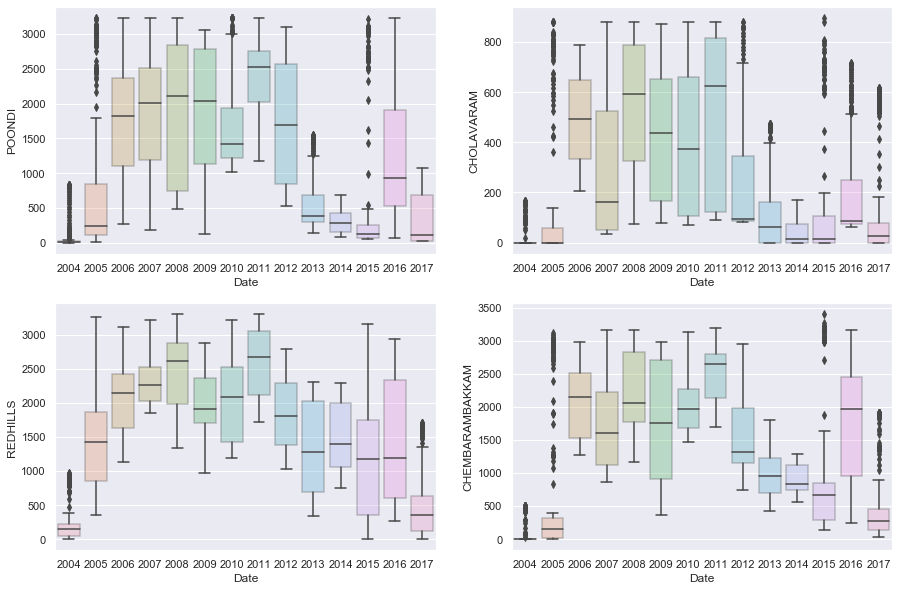

In [10]:
#box plots
f = plt.figure(figsize=(15,10))
for ind, col in enumerate(res_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    sns.boxplot(data=visualize_df[[col]], x=visualize_df.index.year, y = col,  ax = ax, boxprops=dict(alpha=.3))
#     sns.swarmplot(data=train[[col]], x=train.index.year, y = col)

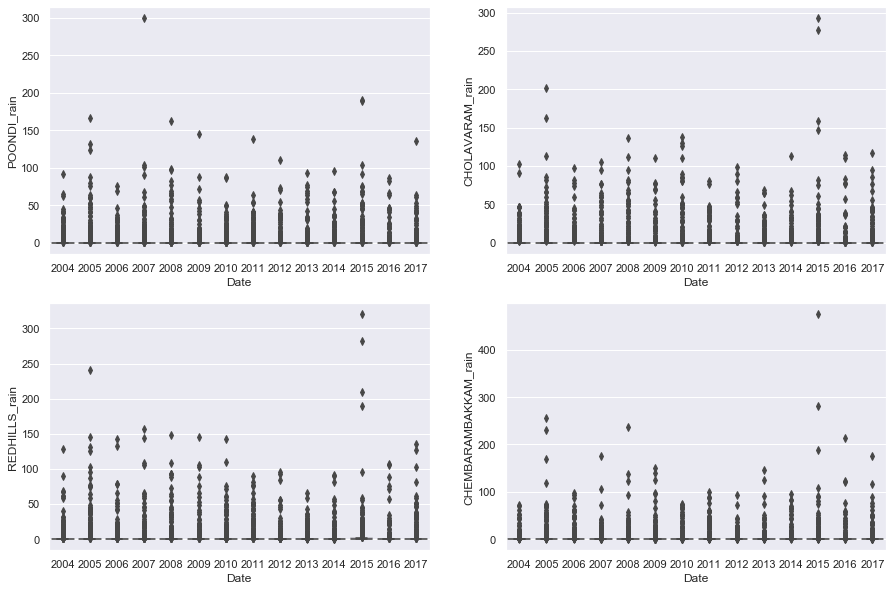

In [11]:
#box plots
f = plt.figure(figsize=(15,10))
for ind, col in enumerate(rain_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    sns.boxplot(data=visualize_df[[col]], x=visualize_df.index.year, y = col,  ax = ax, boxprops=dict(alpha=.3))
#     sns.swarmplot(data=train[[col]], x=train.index.year, y = col)

# Heat Map

## Monthly

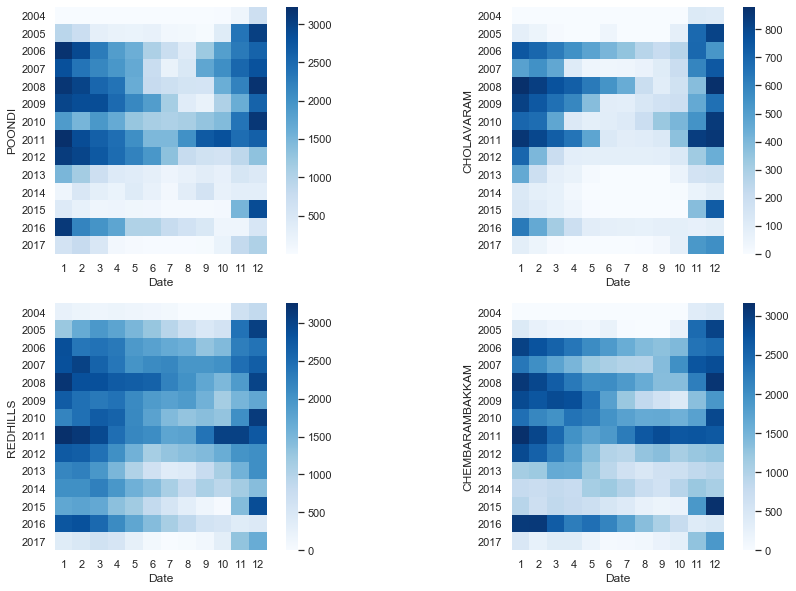

In [12]:
f = plt.figure(figsize=(15,10))
for ind, col in enumerate(res_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    p = sns.heatmap(pandas.pivot_table(data=visualize_df[[col]], index=visualize_df.index.year, columns=visualize_df.index.month),square=True,ax=ax,
           cmap='Blues', xticklabels=list(map(lambda x: str(x), range(1,13))))
#     df = pandas.pivot_table(data=train[[col]], index=train.index.year, columns=train.index.month)
#     df.columns = list(map(lambda x: str(x), range(1,13)))
#     p =df.plot.bar(ax=ax)
    p.set_ylabel(col)
    p.set_xlabel('Date')

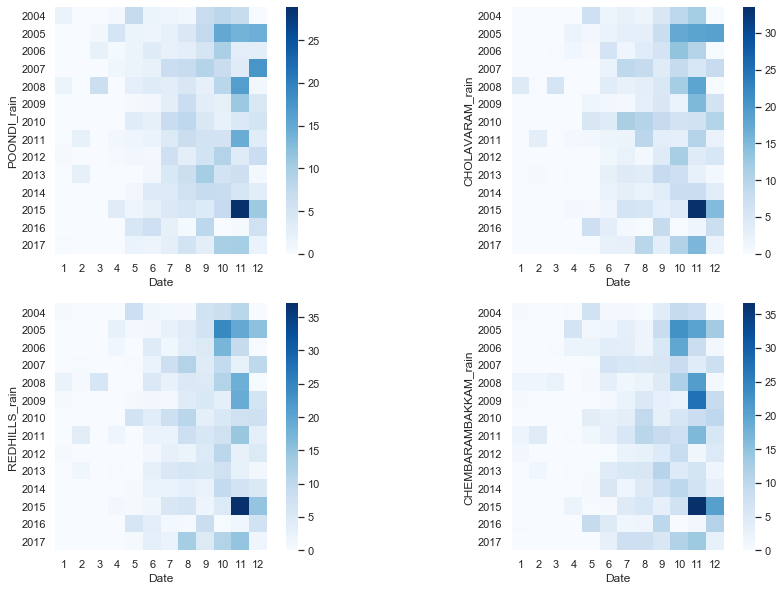

In [13]:
f = plt.figure(figsize=(15,10))
for ind, col in enumerate(rain_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    p = sns.heatmap(pandas.pivot_table(data=visualize_df[[col]], index=visualize_df.index.year, columns=visualize_df.index.month),square=True,ax=ax,
           cmap='Blues', xticklabels=list(map(lambda x: str(x), range(1,13))))
    p.set_ylabel(col)
    p.set_xlabel('Date')

## Quarterly

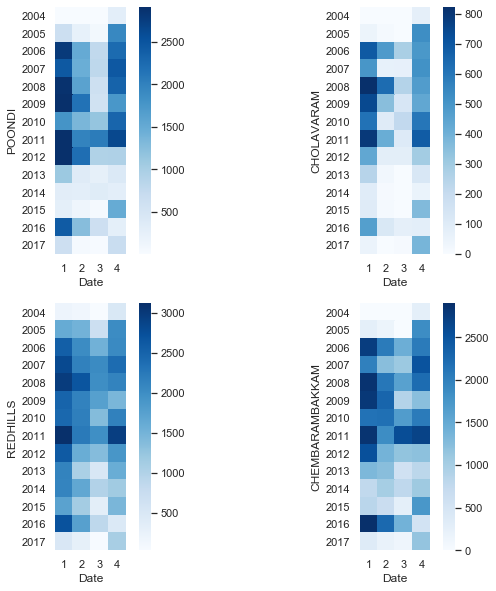

In [14]:
f = plt.figure(figsize=(10,10))
for ind, col in enumerate(res_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    p = sns.heatmap(pandas.pivot_table(data=visualize_df[[col]], index=visualize_df.index.year, columns=visualize_df.index.quarter),square=True,ax=ax,
           cmap='Blues', xticklabels=list(map(lambda x: str(x), range(1,5))))
    p.set_ylabel(col)
    p.set_xlabel('Date')

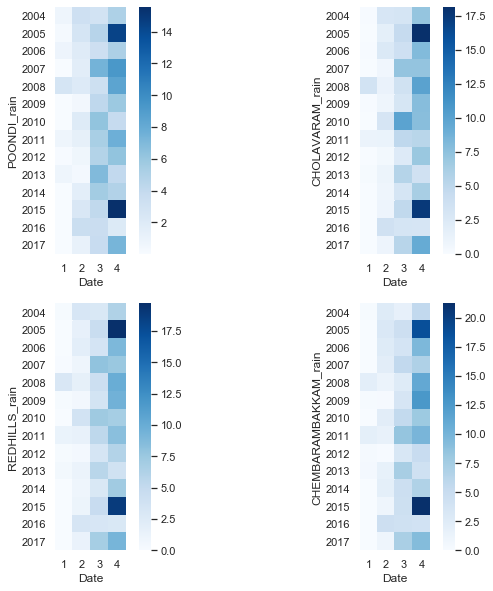

In [15]:
f = plt.figure(figsize=(10,10))
for ind, col in enumerate(rain_df.columns):
    ax = f.add_subplot(2,2,ind+1)
    p = sns.heatmap(pandas.pivot_table(data=visualize_df[[col]], index=visualize_df.index.year, columns=visualize_df.index.quarter),square=True,ax=ax,
           cmap='Blues', xticklabels=list(map(lambda x: str(x), range(1,5))))
    p.set_ylabel(col)
    p.set_xlabel('Date')

In [16]:
# to model the stationarity of the series
# no need of transformation as variance seems to be constant
# depends on lag of rainfall
# deal with outliers 

#full capacity:
# POONDI = 3232
# CHOLAVARAM = 1081
# REDHILLS = 3300
# CHEMBARAMBAKKAM = 3645

# Seasonal Decomposition

## Now doing the analysis only for "POONDI"

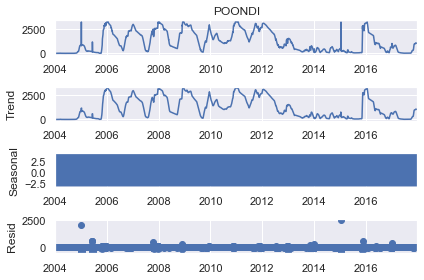

In [17]:
decompose_res = seasonal_decompose(visualize_df["POONDI"])
decompose_res.plot();
plt.rcParams['figure.figsize'] = (20, 10);

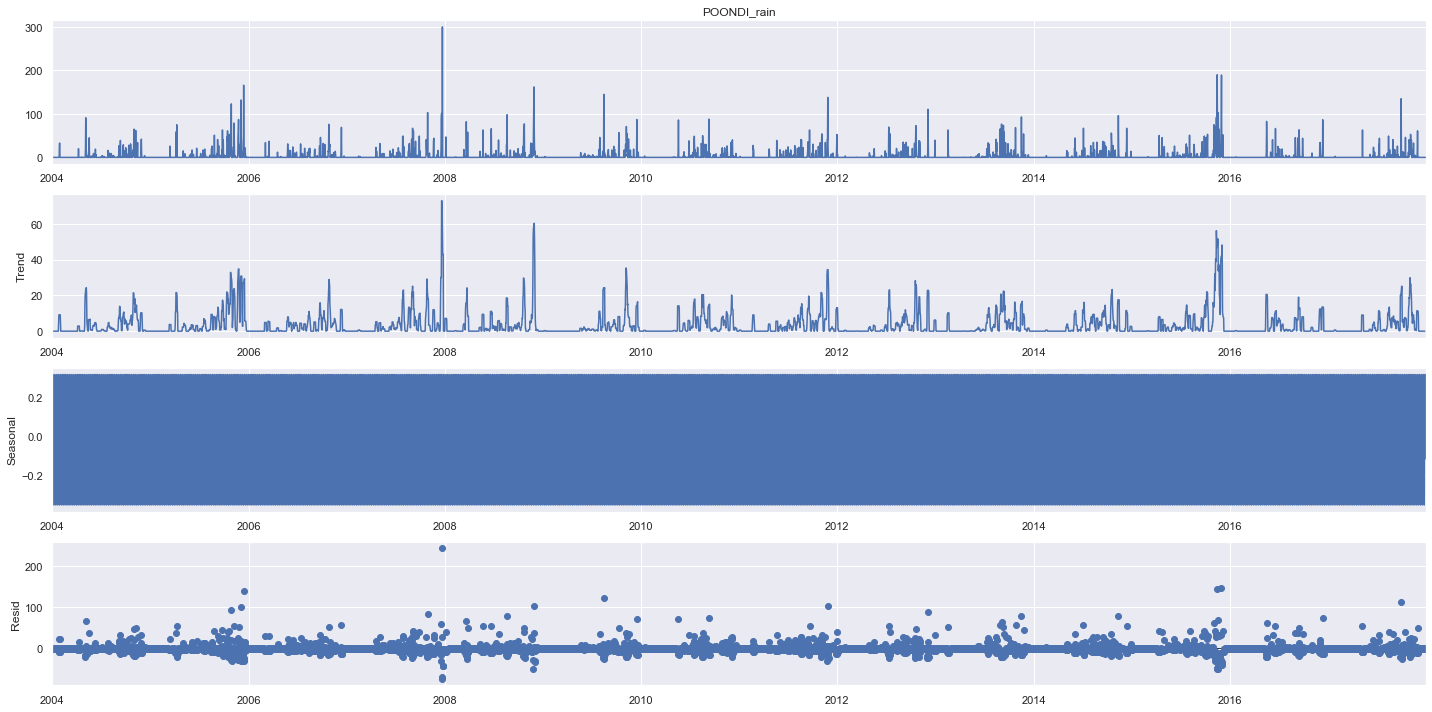

In [18]:
decompose_rain = seasonal_decompose(visualize_df["POONDI_rain"])
decompose_rain.plot();
plt.rcParams['figure.figsize'] = (20, 10);

### Check Whether residual is IID


In [19]:
ljung_p = numpy.mean(ljung(x=decompose_rain.resid.dropna())[1]).round(3)
print("Ljung Box Rainfall, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")


ljung_p = numpy.mean(ljung(x=decompose_res.resid.dropna())[1]).round(3)
print("Ljung Box Reservoir, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")


Ljung Box Rainfall, p value: 0.0 , Residuals are correlated
Ljung Box Reservoir, p value: 0.0 , Residuals are correlated


### It means we haven't decomposed it in a better way, Nice!!!

In [20]:
# checking number of differences required
import pmdarima as pm
from pmdarima.utils import tsdisplay

## ACF Plots
1.) How quickly do the bar lenghts change: If the bars are taping down, that shows presence of trend. Our series has a trend

2.) Pattern: If the ACF shows up/down repeating pattern, it means seasonality with size equal to length of repetition.

3.) Sign of ACF: Alternating signs in ACF shows mean-reversing process whereas if all the ACs are positive (or negative), it shows momentum process.

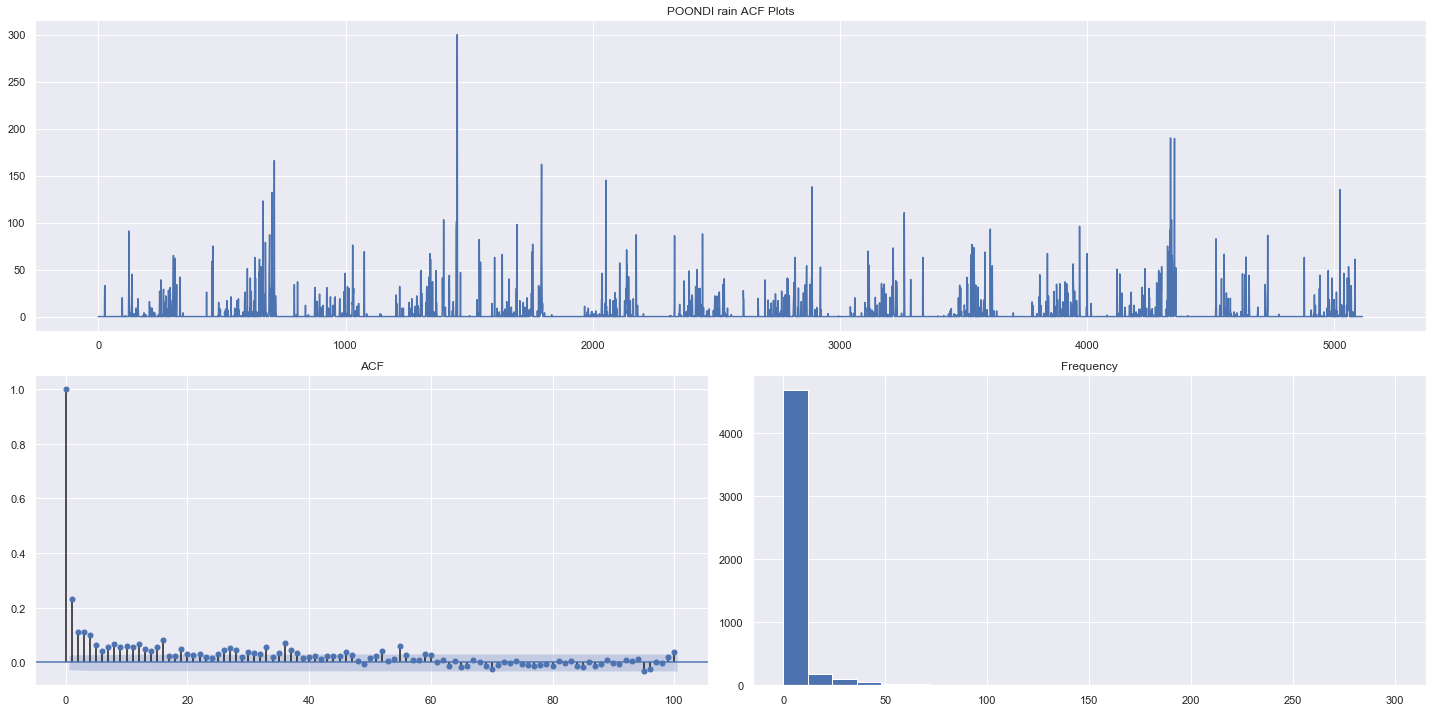

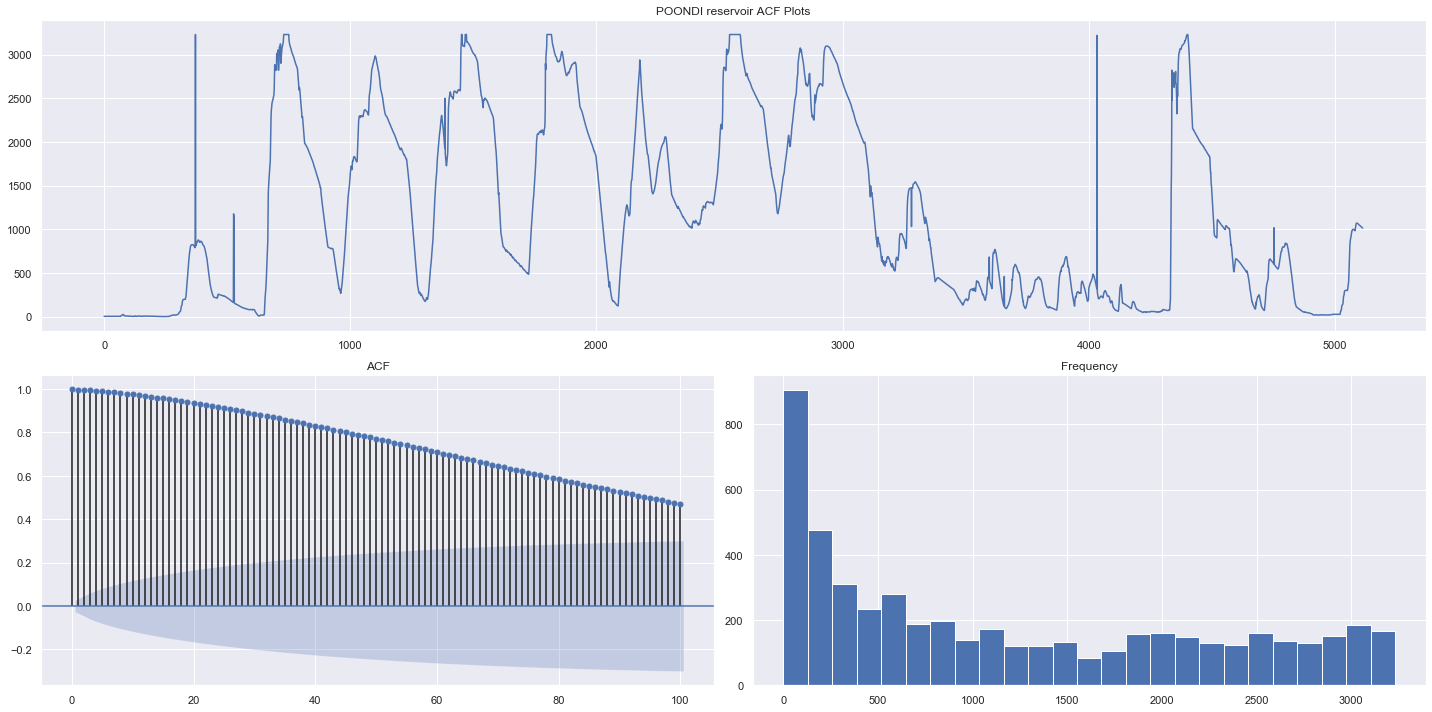

In [21]:
tsdisplay(visualize_df["POONDI_rain"], lag_max = 100, figsize=(20,10), title = 'POONDI rain ACF Plots', acf_kwargs={'alpha':0.05})
tsdisplay(visualize_df["POONDI"], lag_max = 100, figsize=(20,10), title = 'POONDI reservoir ACF Plots', acf_kwargs={'alpha':0.05})

## PACF Plots

Partial autocorrelation, similar to partial correlation, shows correlation after 'partialing out' previous lags. If a series has PACF significant at lag k, it means controlling for other lags <k, lag k has a significant correlation. PACF plot is used to determine order of AR process.

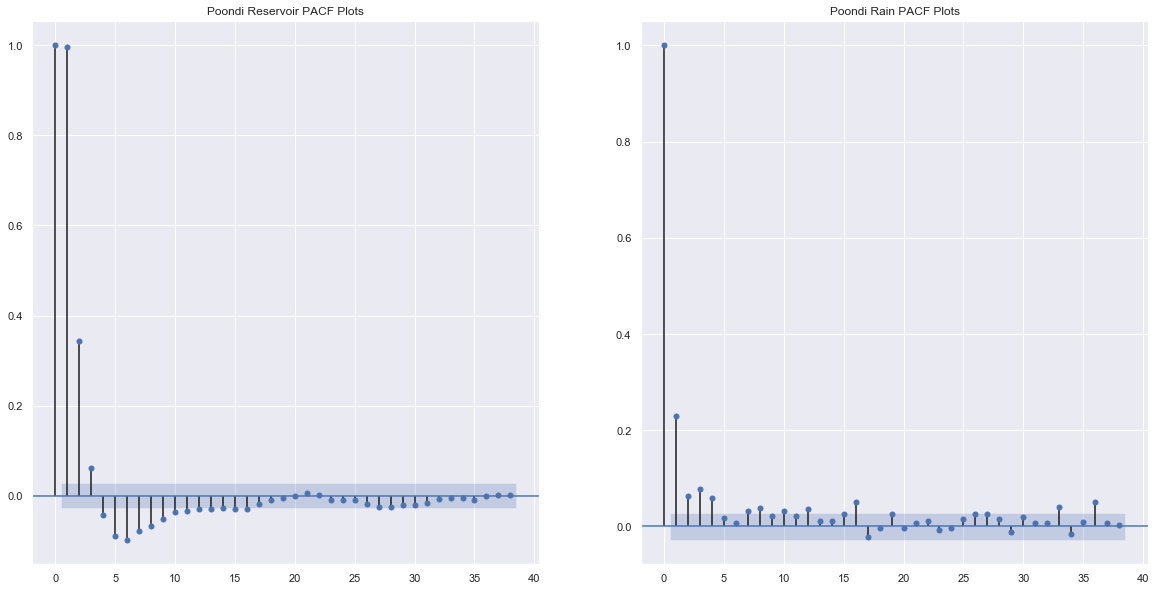

Text(0.5, 0.98, 'PACF Plots')

In [22]:
f = plt.figure(figsize=(20, 10))
ax = f.add_subplot(121)
ax1 = f.add_subplot(122)
pm.plot_pacf(visualize_df['POONDI'], title = 'Poondi Reservoir PACF Plots',ax=ax, alpha=0.05, show=False)
pm.plot_pacf(visualize_df['POONDI_rain'], title = 'Poondi Rain PACF Plots',ax=ax1, alpha=0.05, show=False)
plt.show()
f.suptitle('PACF Plots')

## Checking Differences

In [26]:
# Estimate the number of differences using an ADF test:
y = visualize_df[['POONDI']]
print('---- for POONDI Reservoir')
n_adf = pm.arima.utils.ndiffs(y, test='adf')  # -> 0
print('---adf test--', n_adf)
# Or a KPSS test (auto_arima default):
n_kpss = pm.arima.utils.ndiffs(y, test='kpss')  # -> 0
print('---kpss test--', n_kpss)

# Or a PP test:
n_pp = pm.arima.utils.ndiffs(y, test='pp')  # -> 0
print('---pp test--', n_pp)


#assert n_adf == n_kpss == n_pp == 0

---- for POONDI Reservoir
---adf test-- 0
---kpss test-- 1
---pp test-- 1


In [29]:
# Estimate the number of differences using an ADF test:
y = visualize_df[['POONDI_rain']]
print('---- for POONDI Rainfall')
n_adf = pm.arima.utils.ndiffs(y, test='adf')  # -> 0
print('---adf test--', n_adf)
# Or a KPSS test (auto_arima default):
n_kpss = pm.arima.utils.ndiffs(y, test='kpss')  # -> 0
print('---kpss test--', n_kpss)

# Or a PP test:
n_pp = pm.arima.utils.ndiffs(y, test='pp')  # -> 0
print('---pp test--', n_pp)

#assert n_adf == n_kpss == n_pp == 0

---- for POONDI Rainfall
---adf test-- 0
---kpss test-- 0
---pp test-- 0


## Sumarry
it seems rain is already stationary but reservoir is not

Data is highly positively skewed

Outliers are their
ACF & PACF plots suggests highly auto correlated


In [30]:
## steps to try:
# remove outliers
# transform the data
# remove seasonality in a better way

### Study the variance & mean of the plots

S.D is: 1041.6807352905662


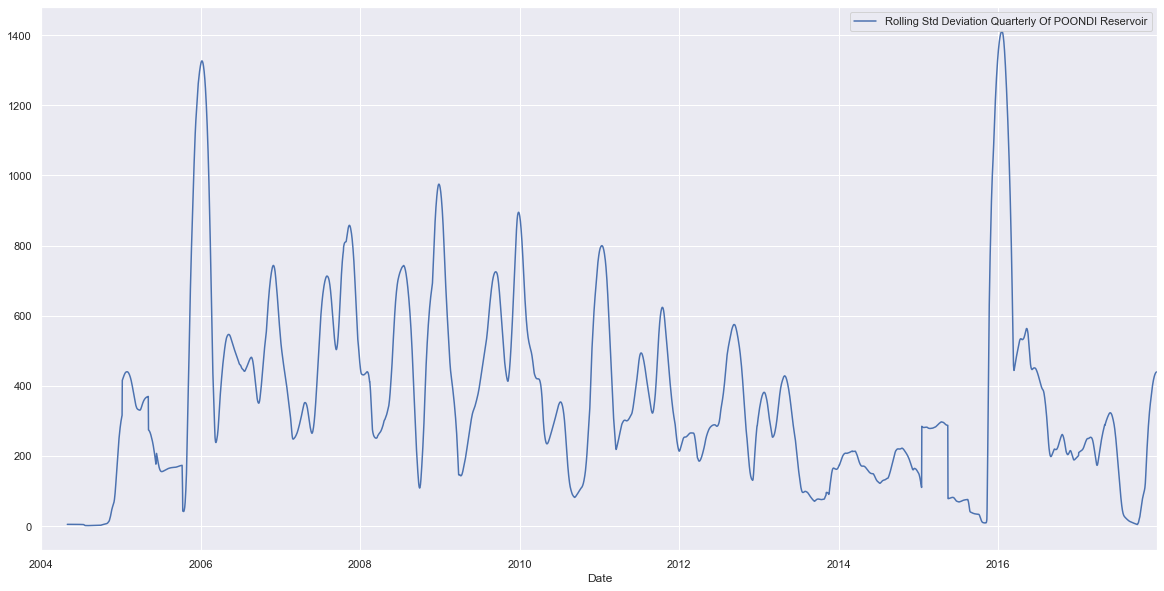

S.D is: 13.23124407130701


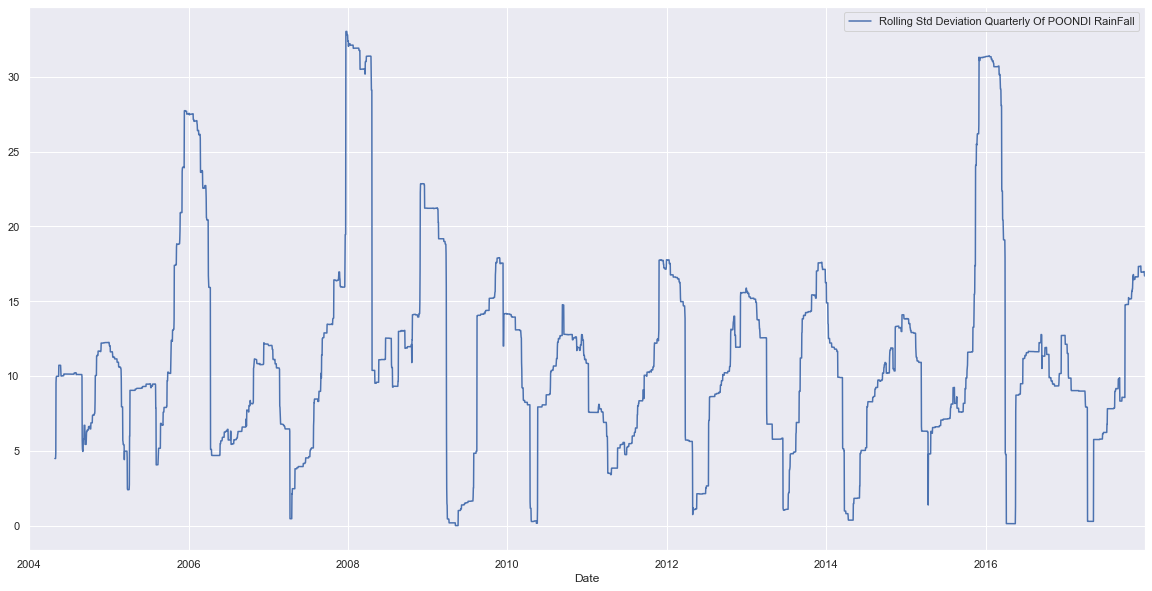

In [31]:
visualize_df["POONDI"].rolling(120).std().plot(legend=True, label="Rolling Std Deviation Quarterly Of POONDI Reservoir");
print("S.D is:", visualize_df["POONDI"].std())
plt.show()
visualize_df["POONDI_rain"].rolling(120).std().plot(legend=True, label="Rolling Std Deviation Quarterly Of POONDI RainFall");
print("S.D is:", visualize_df["POONDI_rain"].std())
plt.show()

### Check the Normality of Series

series does not need to be Gaussian for accurate forecasting but if the data is highly skewed it can affect the model selection and forecast uncertainty. In general, if the series is non-gaussian, it should be normalized before any further transformations (differencing, log, Box Cox) at least to check if normalization helps. Normalization will also help if decide to use regression, tree-based models, NN models later. Note that with normalization, we make the z score between [0,1], with standardization on the other hand , we center the distribution with mean =0, s.d.=1.

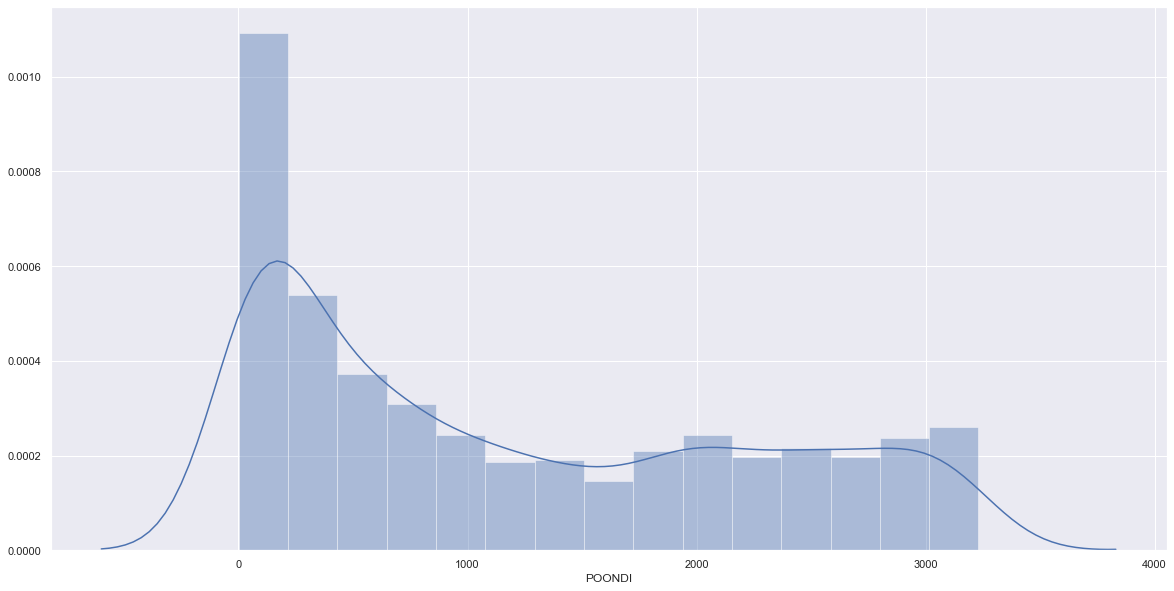

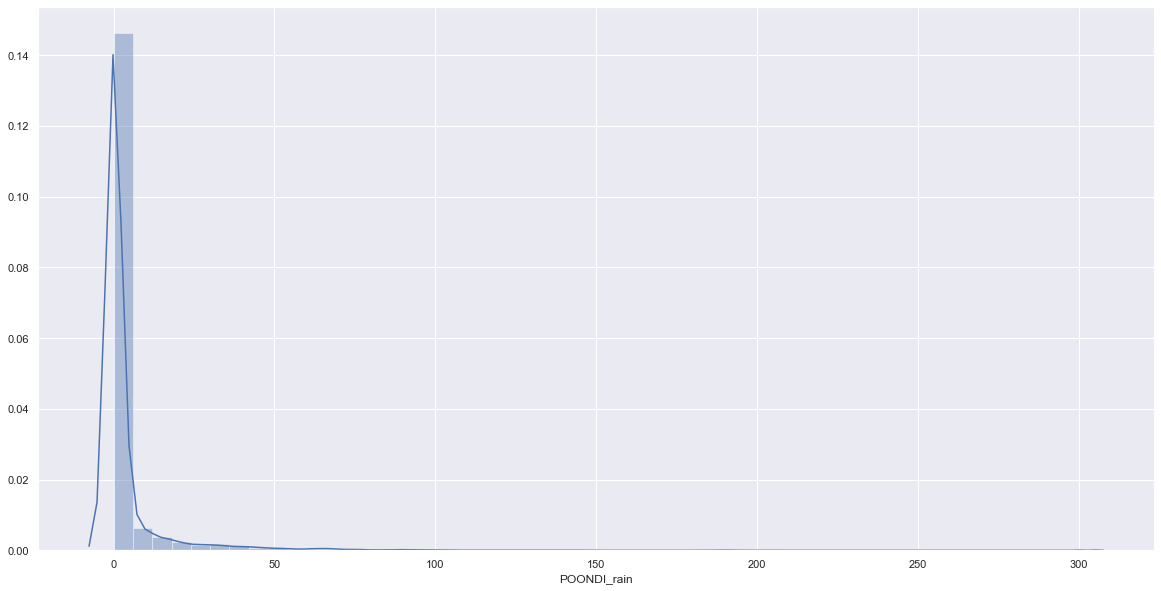

In [32]:
sns.distplot(visualize_df["POONDI"])
plt.show()
sns.distplot(visualize_df["POONDI_rain"])
plt.show()

In [33]:
## doing normality test
# Jaque Barra test
from scipy.stats import jarque_bera as jb
is_norm=jb(visualize_df["POONDI"])[1]
print(f"p value Reservoir:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")

is_norm=jb(visualize_df["POONDI_rain"])[1]
print(f"p value Rain:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")

p value Reservoir:0.0 , Series is Non-Normal
p value Rain:0.0 , Series is Non-Normal


### Notes
Check residuals.

Plot residuals, plot ACF/PACF and Q/Q plots
Conditions A, B below are essential and C,D are useful. Residuals should be:

    1.) Uncorrelated
    2.) Have zero (or close to zero) mean
    3.) Constant variance
    4.) Normally distributed
First two ensure that there is no more information that can be extracted from the data, while the bottom two keep the variability in the point forecast narrow

Evaluation Metric
    
    1.) As a general rule, if the data has no outliers RMSE (Root Mean Square Error) is a good metric to use
    2.) %MAPE (Mean Absolute Percentage Error) provides a more inutitive understanding as it is expressed in 
    percentage. We do not use %MAPE if the series is intermittent to avoid division by zero

# Forecasting Model

### Below are some useful functions, all of them are copied

In [63]:

# Some important function
def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = numpy.array(y_true), numpy.array(y_pred)
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y1,y2):
    
    accuracy_df=pandas.DataFrame()
    
    rms_error = numpy.round(rmse(y1, y2),4)
    
    map_error = numpy.round(MAPE(y1,y2),4)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df


### Holt-Winter's Grid Search
def HWGrid(train, test, seasonal_periods, trend = ['add','mul'], seasonal= ['add','mul'],use_boxcox =[False, True, 'log'] ):
    """
    # copied from a blog @Deepak
    Author: Sandeep Pawar twitter: @PawarBI
    Functions returns a dataframe with parameters of the Holt-Winter's method and corresponding train & test evaluation scores. 
    It also does a quick check of the residuals using Ljung-Box test and Shapiro test for normality. 
    Residuals must be uncorrelated. 
    
    train: (pandas series)
        -  Training data
        
    test: (pandas series)
        -  Test data
    
    Seasonal_periods: int
        - No of seasonas in the time period. e.g. 4 for Quarterly, 12 for Monthly, 52 for Weekly data
        
    """

    import itertools
    damped     = [False, True]

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    result_df = pandas.DataFrame(columns=['Trend', 'Seasonal', 'Damped', 'BoxCox','AICc Train',  
                                      '%MAPE_Train', 'RMSE_Train', '%MAPE_Test', 
                                      'RMSE_Test', "Resid_LJ", "Resid_Norm","Resid_mean" ])
    
    
    for trend,seasonal,damped,use_boxcox in params:
    
            model = ExponentialSmoothing(train, 
                                     trend=trend,
                                     damped=damped,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods).fit(use_boxcox=use_boxcox)
    
    
            
            mape1=MAPE(train,model.fittedvalues) 
            rmse1=rmse(train,model.fittedvalues)

            mape2=MAPE(test,model.forecast(len(test))) 
            rmse2=rmse(test,model.forecast(len(test)))

            aicc1 = model.aicc.round(1)

               
    
            lj_p_val = numpy.mean(ljung(x=model.resid, lags=10)[1])
            norm_p_val =  jb(model.resid)[1]#shapiro(model.resid)[1]
    
            lj = "Uncorrelated" if lj_p_val > 0.05 else "Correlated"
            norm = "Normal" if norm_p_val > 0.05 else "Non-Normal"
            
    
            result_df = result_df.append({'Trend':trend       ,
                              'Seasonal': seasonal            ,
                              'Damped':damped                 ,
                              'BoxCox':use_boxcox             ,
                              '%MAPE_Train':numpy.round(mape1,2) ,
                              'RMSE_Train':numpy.round(rmse1,1)  ,
                              'AICc Train':aicc1              ,
                              '%MAPE_Test':numpy.round(mape2,2)  ,
                              'RMSE_Test':numpy.round(rmse2,1)   ,
                              'Resid_LJ' :lj                  ,
                              'Resid_Norm':norm               ,
                              'Resid_mean':numpy.round(model.resid.mean(),1)} , ignore_index=True, sort=False)
    
    
    return result_df.sort_values(by=["RMSE_Test", "%MAPE_Test","RMSE_Train","%MAPE_Train"])

### Calculating cross-validation score for Holt-Winter's method in Python


In [35]:
def hw_cv(series, seasonal_periods, initial_train_window, test_window):
    
    from statsmodels.tools.eval_measures import rmse
    import warnings
    warnings.filterwarnings("ignore")
    
    """
     Author: Sandeep Pawar
     Date: 4/15/2020
     Ver: 1.0
     
     Returns Rolling and Expanding cross-validation scores (avg rmse), along with model paramters
     for Triple Exponential Smoothing method. Expanding expands the training set each time by adding one observation, 
     while rolling slides the training and test by one observation each time. 
     
     Output shows parameters used and Rolling & Expanding cv scores. Output is in below order:
          1. Trend 2. Seasonal 3. Damped 4. use_boxcox 5. Rolling cv 6. Expanding cv 
     
     Requirements: Pandas, Numpy, Statsmodels, itertools, rmse 
     
     series: Pandas Series
             Time series 
     
     seasonal_periods: int
             No of seasonal periods in a full cycle (e.g. 4 in quarter, 12 in monthly, 52 in weekly data)
             
     initial_train_window: int
             Minimum training set length. Recommended to use minimum 2 * seasonal_periods
     
     test_window: int
             Test set length. Recommended to use equal to forecast horizon
             
     e.g. hw_cv(ts["Sales"], 4, 12, 6 )
          Output: add add False False    R: 41.3   ,E: 39.9

          
     Note: This function can take anywhere from 5-15 min to run full output        
    
    """
    
    
    def expanding_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[:(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1


        return numpy.mean(errors_roll).round(1)

    def rolling_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[(i):(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1

   
        return numpy.mean(errors_roll).round(1)
   
    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    for trend,seasonal,damped,use_boxcox in params:
        r=rolling_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        e=expanding_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        result = print(trend, seasonal, damped, use_boxcox,"   R:", r,"  ,E:", e)
          
    return result

In [36]:
def residcheck(residuals, lags):

    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = numpy.mean(residuals)
    lj_p_val = numpy.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", numpy.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", numpy.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", numpy.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", numpy.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax

In [37]:
### using BoxCox Transformation

#Creating BxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["POONDI"])
print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["POONDI"], lmbda=bcox_lam)

train_log = numpy.log(train["POONDI"])

BoxCox parameter to linearize the series: 0.36


# Seasonal Naive (Base Model)

    Seasonal naive method uses the observations from the corresponding season from last period. It does not take any trend 
    or previous history into account. This method, as expected, is not the most accurate but helps create a baseline. 

In [38]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=numpy.int(numpy.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=numpy.tile(last_season,reps)
        
        fcast=pandas.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [39]:
# predictions will have results of all the models
predictions = test[['POONDI']].copy()
predictions_rain = test[['POONDI_rain']].copy()
predictions_diff1 = test_diff1[['POONDI']].copy()
predictions_rain_diff1 = test_diff1[['POONDI_rain']].copy()

py_snaive_fit1, py_snaive_fcast1 = pysnaive(train["POONDI"], seasonal_periods=365,forecast_horizon=365)
py_snaive_fit2, py_snaive_fcast2 = pysnaive(train_diff1["POONDI"], seasonal_periods=365,forecast_horizon=365)
py_snaive_fit3, py_snaive_fcast3 = pysnaive(train["POONDI_rain"], seasonal_periods=365,forecast_horizon=365)
py_snaive_fit4, py_snaive_fcast4 = pysnaive(train_diff1["POONDI_rain"], seasonal_periods=365,forecast_horizon=365)

#Residuals
py_snaive_resid1 = (train["POONDI"] - py_snaive_fit1).dropna()
predictions["py_snaive"] = py_snaive_fcast1.values 

py_snaive_resid2 = (train_diff1["POONDI"] - py_snaive_fit2).dropna()
predictions_diff1["py_snaive"] = py_snaive_fcast2.values 

py_snaive_resid3 = (train["POONDI_rain"] - py_snaive_fit3).dropna()
predictions_rain["py_snaive"] = py_snaive_fcast3.values 

py_snaive_resid4 = (train_diff1["POONDI_rain"] - py_snaive_fit4).dropna()
predictions_rain_diff1["py_snaive"] = py_snaive_fcast4.values 

##### Seasonal naive model for POONDI

Text(0.5, 1.0, 'POONDI Seasonal Naive Plots')

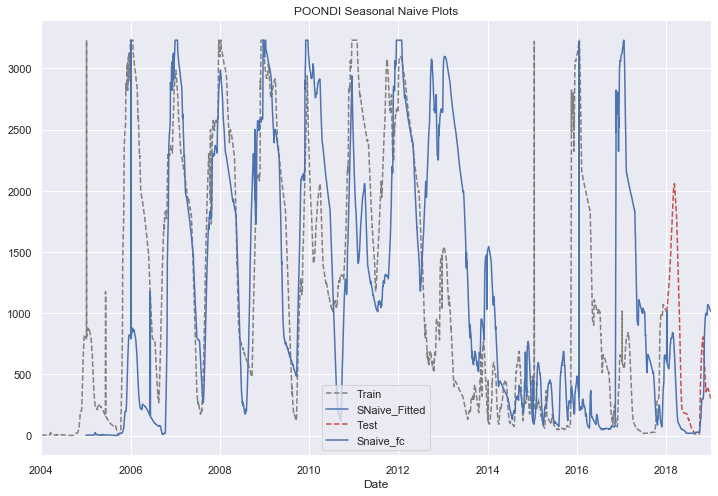

In [41]:
# let's plot the forecast
pandas.plotting.register_matplotlib_converters()
train["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
py_snaive_fit1.plot(color="b", legend=True, label="SNaive_Fitted")
predictions["POONDI"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc")
plt.title("POONDI Seasonal Naive Plots")

seeing the accuracy of the model on trianing set
      %MAPE       RMSE
0  223.9541  1022.8802 

seeing the accuracy of the model on test set
    %MAPE      RMSE
0  85.855  649.3457 

checking the residuals of the model 

** Mean of the residuals:  21.08

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.002 (<0.05, Stationary)


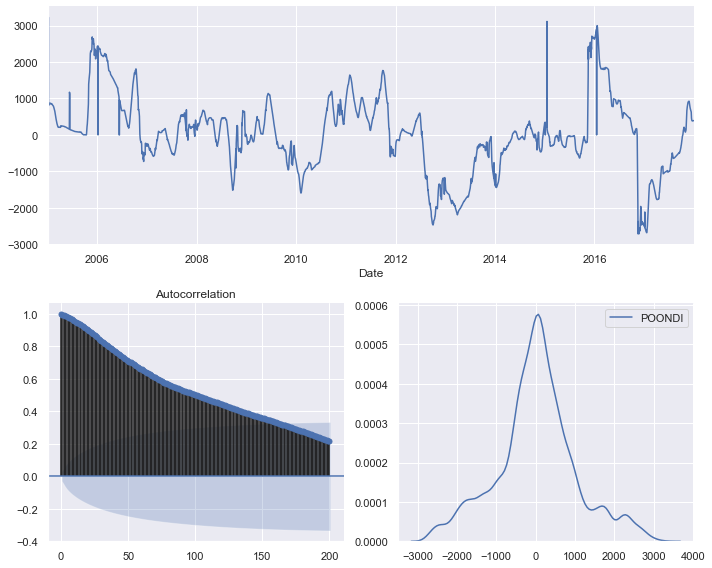

In [47]:
# Accuracy of the model
print("seeing the accuracy of the model on trianing set")
print(accuracy(train["POONDI"].iloc[-len(py_snaive_fit1.dropna()):], py_snaive_fit1.dropna()), '\n')
print("seeing the accuracy of the model on test set")
print(accuracy(predictions["POONDI"], predictions["py_snaive"]),'\n')

print('checking the residuals of the model \n')

residcheck(py_snaive_resid1.dropna(), lags = 200);

##### Seasonal naive model for POONDI with d=1

Text(0.5, 1.0, 'POONDI Seasonal Naive Plots with d=1')

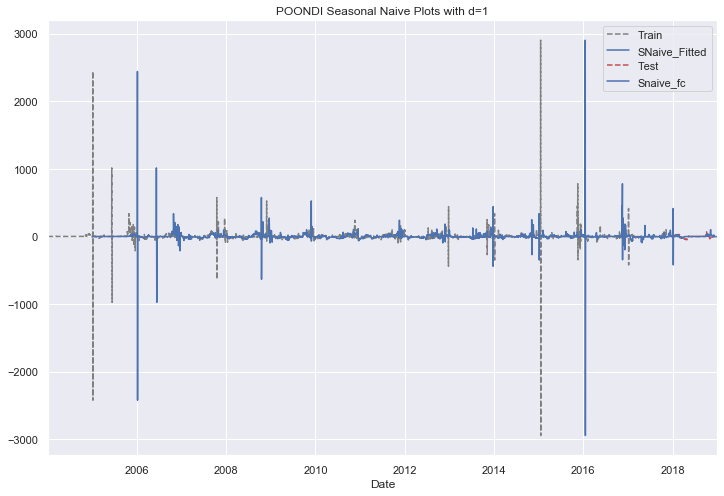

In [42]:
# let's plot the forecast
pandas.plotting.register_matplotlib_converters()
train_diff1["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
py_snaive_fit2.plot(color="b", legend=True, label="SNaive_Fitted")
predictions_diff1["POONDI"].plot(style="--",color="r", legend=True, label="Test")
predictions_diff1["py_snaive"].plot(color="b", legend=True, label="Snaive_fc")
plt.title("POONDI Seasonal Naive Plots with d=1")

seeing the accuracy of the model on trianing set
   %MAPE      RMSE
0    NaN  124.5163 

seeing the accuracy of the model on test set
   %MAPE     RMSE
0    NaN  37.5791 

checking the residuals of the model 

** Mean of the residuals:  -0.09

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


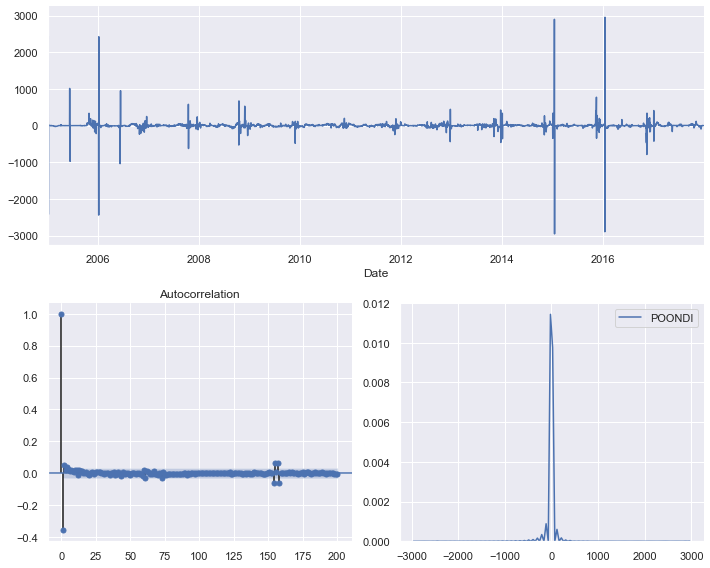

In [48]:
# Accuracy of the model
print("seeing the accuracy of the model on trianing set")
print(accuracy(train_diff1["POONDI"].iloc[-len(py_snaive_fit2.dropna()):], py_snaive_fit2.dropna()), '\n')
print("seeing the accuracy of the model on test set")
print(accuracy(predictions_diff1["POONDI"], predictions_diff1["py_snaive"]),'\n')

print('checking the residuals of the model \n')

residcheck(py_snaive_resid2.dropna(), lags = 200);

##### Seasonal naive model for POONDI rain

Text(0.5, 1.0, 'POONDI Rain Seasonal Naive Plots')

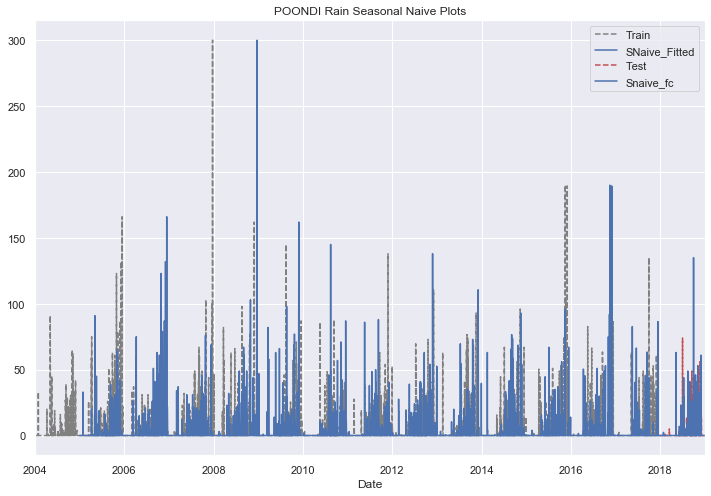

In [44]:
# let's plot the forecast
pandas.plotting.register_matplotlib_converters()
train["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
py_snaive_fit3.plot(color="b", legend=True, label="SNaive_Fitted")
predictions_rain["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")
predictions_rain["py_snaive"].plot(color="b", legend=True, label="Snaive_fc")
plt.title("POONDI Rain Seasonal Naive Plots")

seeing the accuracy of the model on trianing set
   %MAPE     RMSE
0    NaN  18.6915 

seeing the accuracy of the model on test set
   %MAPE     RMSE
0    NaN  12.6088 

checking the residuals of the model 

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


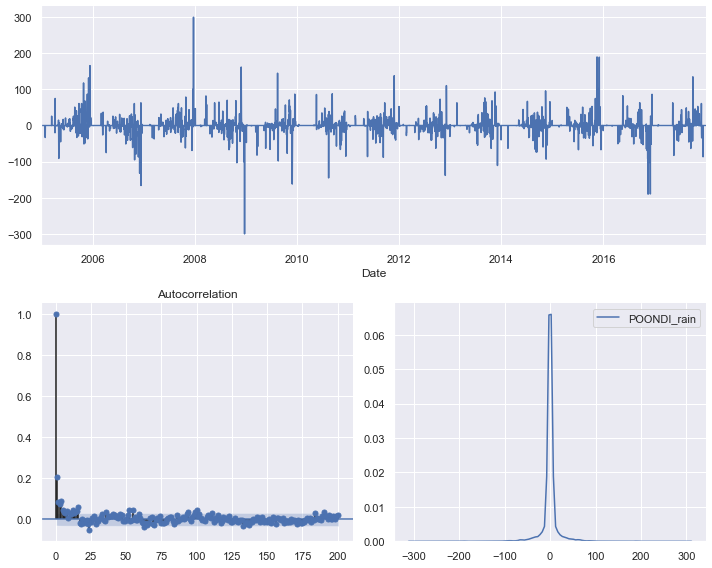

In [49]:
# Accuracy of the model
print("seeing the accuracy of the model on trianing set")
print(accuracy(train["POONDI_rain"].iloc[-len(py_snaive_fit3.dropna()):], py_snaive_fit3.dropna()), '\n')
print("seeing the accuracy of the model on test set")
print(accuracy(predictions_rain["POONDI_rain"], predictions_rain["py_snaive"]),'\n')

print('checking the residuals of the model \n')

residcheck(py_snaive_resid3.dropna(), lags = 200);

##### Seasonal naive model for POONDI rain with d=1

Text(0.5, 1.0, 'POONDI Rain Seasonal Naive Plots with d=1')

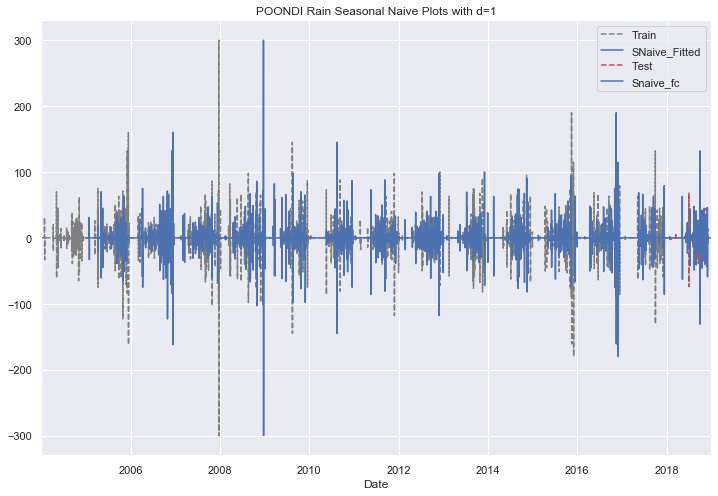

In [45]:
# let's plot the forecast
pandas.plotting.register_matplotlib_converters()
train_diff1["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
py_snaive_fit4.plot(color="b", legend=True, label="SNaive_Fitted")
predictions_rain_diff1["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")
predictions_rain_diff1["py_snaive"].plot(color="b", legend=True, label="Snaive_fc")
plt.title("POONDI Rain Seasonal Naive Plots with d=1")

seeing the accuracy of the model on trianing set
   %MAPE     RMSE
0    NaN  23.5804 

seeing the accuracy of the model on test set
   %MAPE     RMSE
0    NaN  16.4649 

checking the residuals of the model 

** Mean of the residuals:  -0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


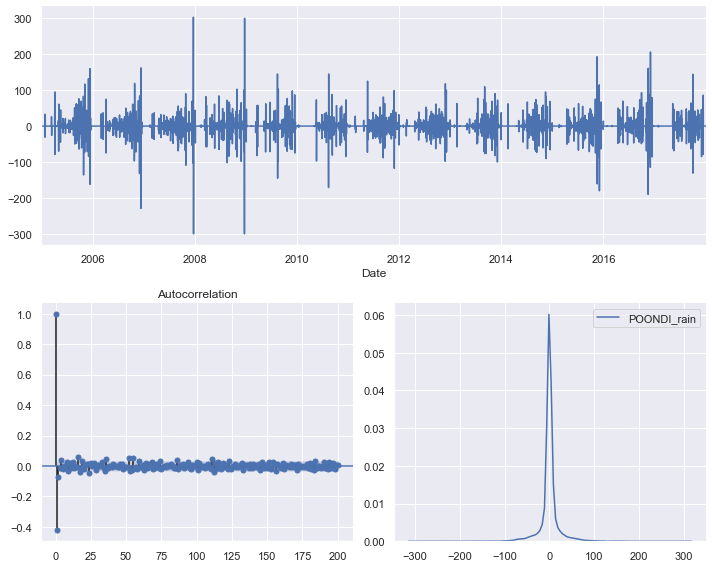

In [50]:
# Accuracy of the model
print("seeing the accuracy of the model on trianing set")
print(accuracy(train_diff1["POONDI_rain"].iloc[-len(py_snaive_fit4.dropna()):], py_snaive_fit4.dropna()), '\n')
print("seeing the accuracy of the model on test set")
print(accuracy(predictions_rain_diff1["POONDI_rain"], predictions_rain_diff1["py_snaive"]),'\n')

print('checking the residuals of the model \n')

residcheck(py_snaive_resid4.dropna(), lags = 200);

### Some important notes
    Residual analysis shows residuls are not stationary and have non-zero mean. Residual plot clearly shows that the model hasn't extracted the trend and seasonal behaviour as well as we would like. Though visually the model seems to perform well, it's not a useful model on its own
    Non-zero mean can be fixed by adding the mean back to the forecasts as explained here but in this case the mean is significantly away from zero.
    We could perhaps fit an AR model to the residuals to get more out of it.

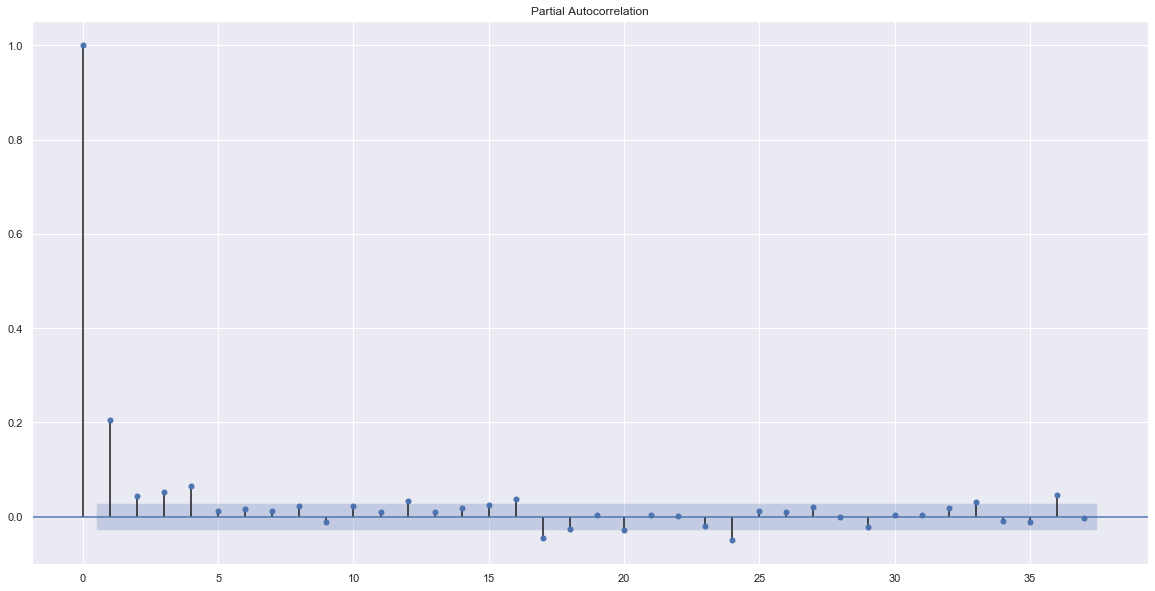

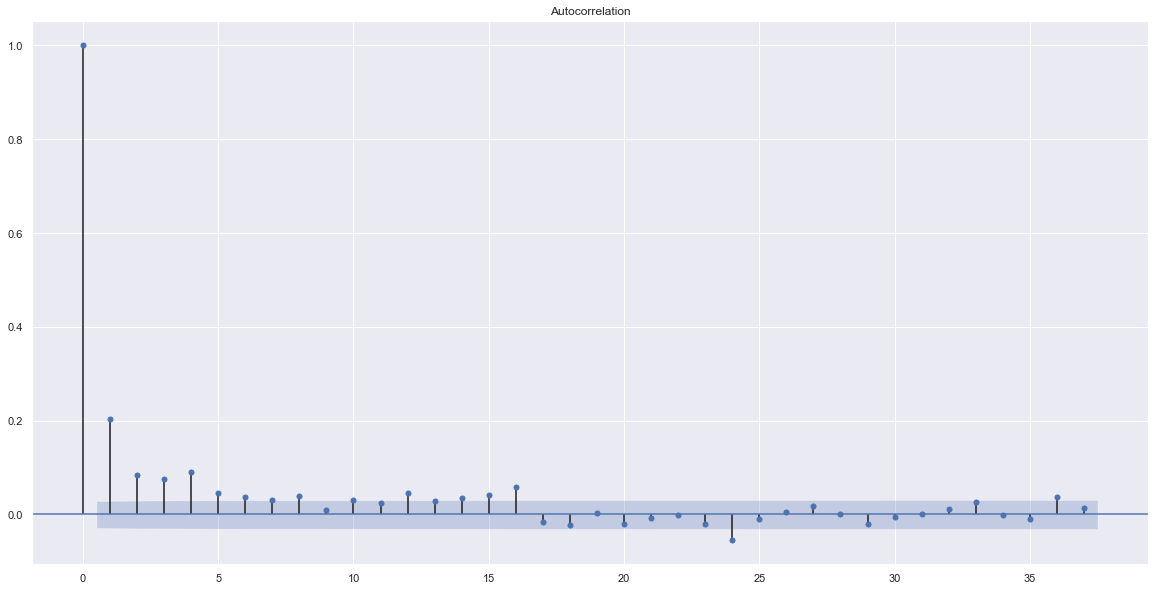

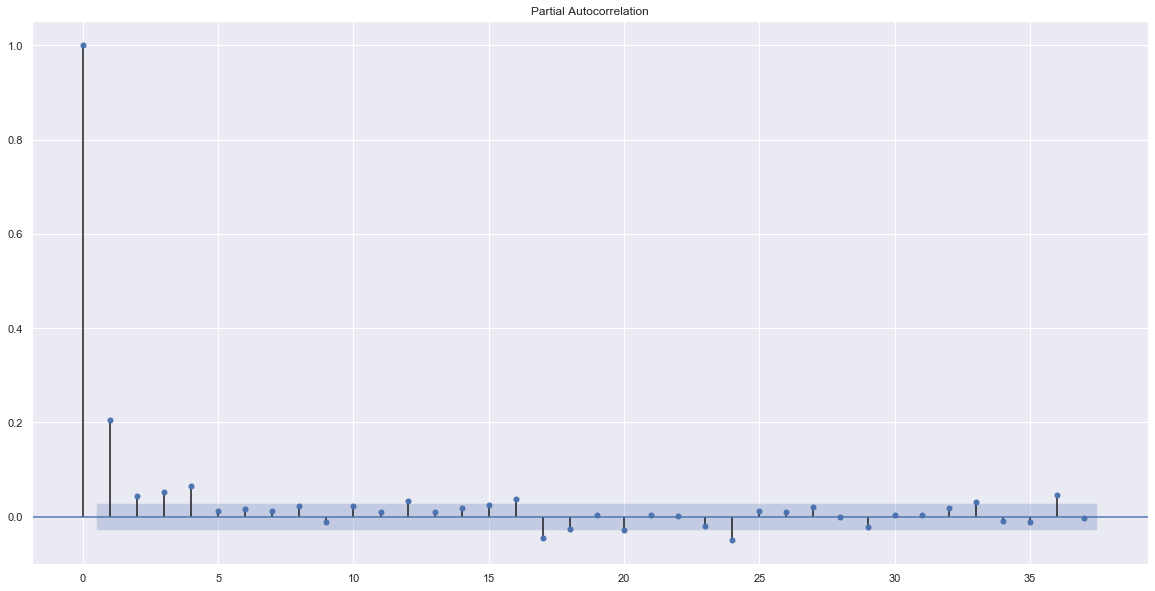

In [51]:
plot_acf(py_snaive_resid3)
plot_pacf(py_snaive_resid3)

# Triple Exponential Smoothing (Holt-Winter's Method)

    Triple Exponential Smoothing (Holt Winter's method) decomposes the series into level, trend, seasonality. Future values are predicted by combining these systematic factors based on recent history. The intuitive idea here is that the future will behave very similar to recent past, we just have to find how much of the past is relevant. The three systematic components are:
> Level, (alpha): Average value around which the series varies. For a seasonal time series, level is obtained by first #de-seasonalizing the series and then averaging. Alpha value determines how much of the past to consider and is between [0,1]. alpha=1 means give importance only to the last data point (naive forecast)

> Trend, (beta): Trend is how the level changes over time. Similar to alpha, a beta value closer to 1 indicates the model is considering only the recent trend. Trend also has a damping factor (phi) which determines how much of the recent trend to 'forget'. Consider it as a de-rating factor on trend.

> Seasonality (gamma): This factor models how the series behaves in each time period for full season. Recall that in the previous blog about EDA (Part 1), I calculated the seasonal factors. Gamma is the same thing.

    This method is called "Exponential" because each of the above factors give exponential weightage to the past values.

<code>              Additive model = (Level + Trend) + Seasonality <code>
<code>           Multiplicative Model = (Level Trend) Seasonality  <code>

    The Exponentialsmoothing() method in statsmodels finds the optimal alpha, beta, gamma and phi by minizing the errors.

#### Additive vs Multiplicative
> Depending on the temporal structure of the time series, trend and seasonality can show additive, multiplicative or mix behaviour.
    
> In case of trend, if the time series has linear trend, it's additive. If it is exponentially increasing (power law), a multiplicative model might fit better.
    
> Seasonality is calculated relative to the level. If a series has additive seasonality, each season varies +/- relative to the level. E.g. in a quarterly series, in Q1 we might add +30 more units, -60 in Q2, +120 in Q3 and +60 in Q4 relative to level. Thus, seasonality peaks have somehwat fix height relative to level everywhere. On the other hand, in a multiplicative seasonality, the quantities will vary by %, i.e +5% in Q1, -7% in Q2, +10% in Q3 and +5 in Q4 relative to trend. As the level increases or decreases, seasonality can vary by %.

In [64]:
# m1=HWGrid(train["POONDI"], test["POONDI"], seasonal_periods=365, use_boxcox=[False, True, 'log'])
m2=HWGrid(train_diff1["POONDI"], test_diff1["POONDI"], seasonal_periods=365,trend= ['add'], seasonal= ['add'],use_boxcox=[False])
m3=HWGrid(train["POONDI_rain"], test["POONDI_rain"], seasonal_periods=365, trend= ['add'], seasonal= ['add'],use_boxcox=[False])
m4=HWGrid(train_diff1["POONDI_rain"], test_diff1["POONDI_rain"], seasonal_periods=365,trend= ['add'], seasonal= ['add'], use_boxcox=[False])

In [79]:
# m.style.format({"%MAPE_Train": "{:20,.2f}%", "%MAPE_Test": "{:20,.2f}%"}).highlight_min(color='lightgreen')
m4

,Trend,Seasonal,Damped,BoxCox,AICc Train,%MAPE_Train,RMSE_Train,%MAPE_Test,RMSE_Test,Resid_LJ,Resid_Norm,Resid_mean
0,add,add,False,False,29639.8,inf,16.8,inf,10.2,Correlated,Non-Normal,-0.0
1,add,add,True,False,29631.5,inf,16.8,inf,10.2,Correlated,Non-Normal,0.0


#### Holt's winter for POONDI

In [67]:
hw_model1 = ExponentialSmoothing(train["POONDI"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=True)

hw_fitted1 = hw_model1.fittedvalues

hw_resid1 = hw_model1.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model1.forecast(len(test["POONDI"])) + numpy.mean(hw_resid1)

predictions["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.795818,True
smoothing_trend,beta,0.000002,True
smoothing_seasonal,gamma,0.000064,True
initial_level,l.0,24.696437,True
initial_trend,b.0,0.005693,True
...,...,...,...
initial_seasons.360,s.360,-22.824142,True
initial_seasons.361,s.361,-22.559222,True
initial_seasons.362,s.362,-22.626223,True
initial_seasons.363,s.363,-22.717593,True


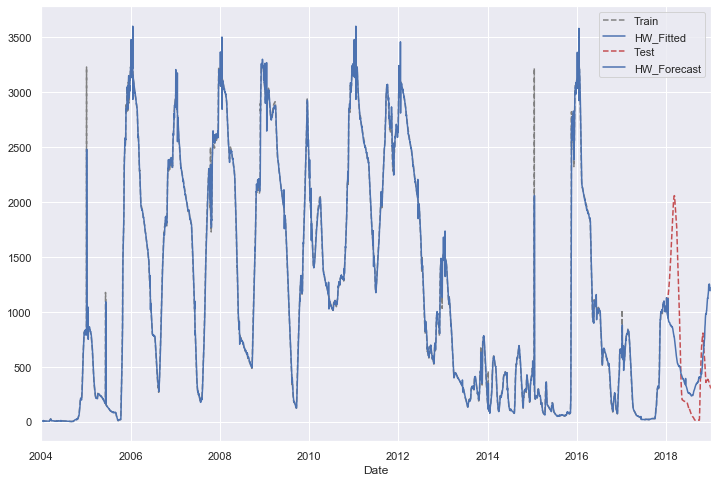

In [68]:
train["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted1.plot(color="b", legend=True, label="HW_Fitted")
predictions["POONDI"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

In [69]:
accuracy(predictions['POONDI'],predictions["py_hw"] )

,%MAPE,RMSE
0,399.9571,570.936


** Mean of the residuals:  0.33

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


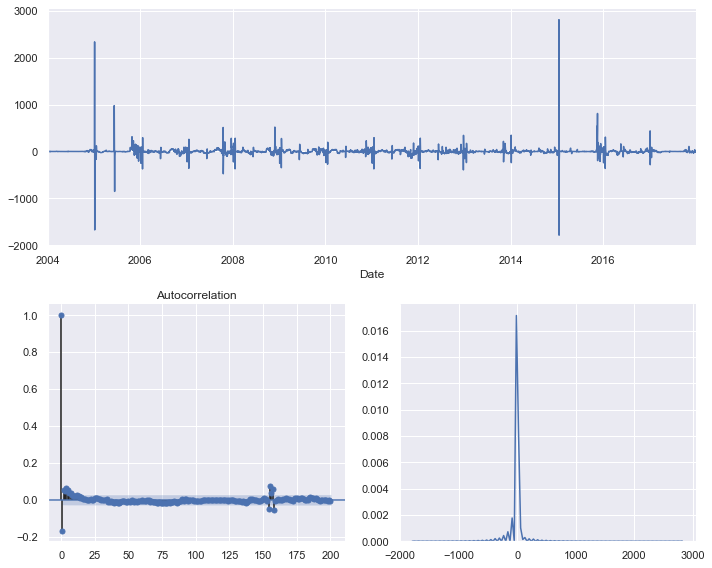

In [83]:
residcheck(hw_resid1.dropna(), lags = 200);

#### Holt's winter for POONDI with d=1

In [70]:
hw_model2 = ExponentialSmoothing(train_diff1["POONDI"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=False)

hw_fitted2 = hw_model2.fittedvalues

hw_resid2 = hw_model2.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model2.forecast(len(test_diff1["POONDI"])) + numpy.mean(hw_resid2)

predictions_diff1["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.005000,True
smoothing_trend,beta,0.000100,True
smoothing_seasonal,gamma,0.000100,True
initial_level,l.0,6.499973,True
initial_trend,b.0,-0.000169,True
...,...,...,...
initial_seasons.360,s.360,-6.498846,True
initial_seasons.361,s.361,-6.500050,True
initial_seasons.362,s.362,-9.199906,True
initial_seasons.363,s.363,-12.099694,True


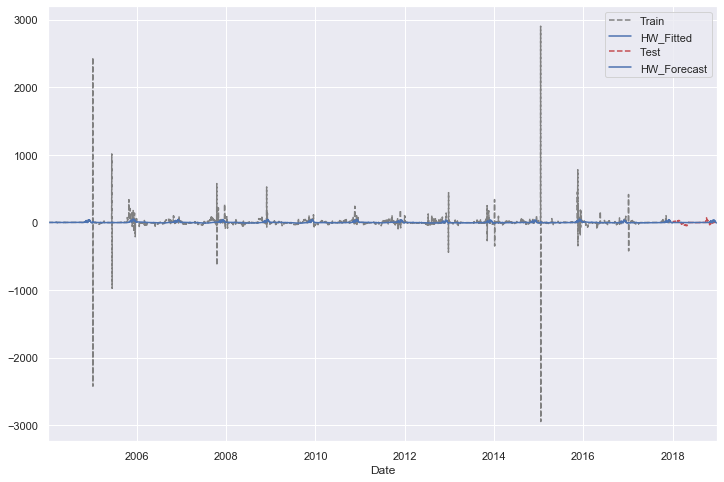

In [71]:
train_diff1["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted2.plot(color="b", legend=True, label="HW_Fitted")
predictions_diff1["POONDI"].plot(style="--",color="r", legend=True, label="Test")
predictions_diff1["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

In [72]:
accuracy(predictions_diff1['POONDI'],predictions_diff1["py_hw"] )

,%MAPE,RMSE
0,inf,20.1996


** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


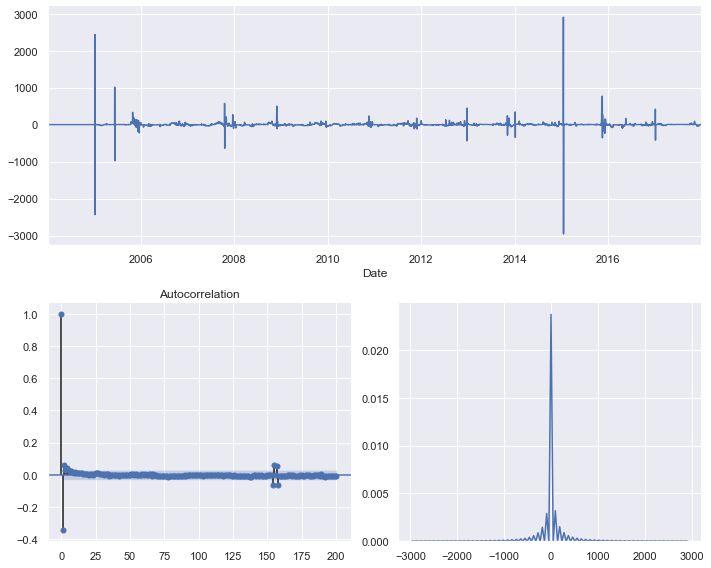

In [84]:
residcheck(hw_resid2.dropna(), lags = 200);

#### Holt's winter for POONDI rain

In [91]:
hw_model3 = ExponentialSmoothing(train["POONDI_rain"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=False)

hw_fitted3 = hw_model3.fittedvalues

hw_resid3 = hw_model3.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model3.forecast(len(test["POONDI_rain"])) + numpy.mean(hw_resid3)

predictions_rain["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model3.params_formatted

,name,param,optimized
smoothing_level,alpha,0.127649,True
smoothing_trend,beta,0.000369,True
smoothing_seasonal,gamma,0.191509,True
initial_level,l.0,-3.461127,True
initial_trend,b.0,-0.000768,True
...,...,...,...
initial_seasons.360,s.360,-2.654472,True
initial_seasons.361,s.361,-2.646188,True
initial_seasons.362,s.362,-2.631895,True
initial_seasons.363,s.363,-2.608765,True


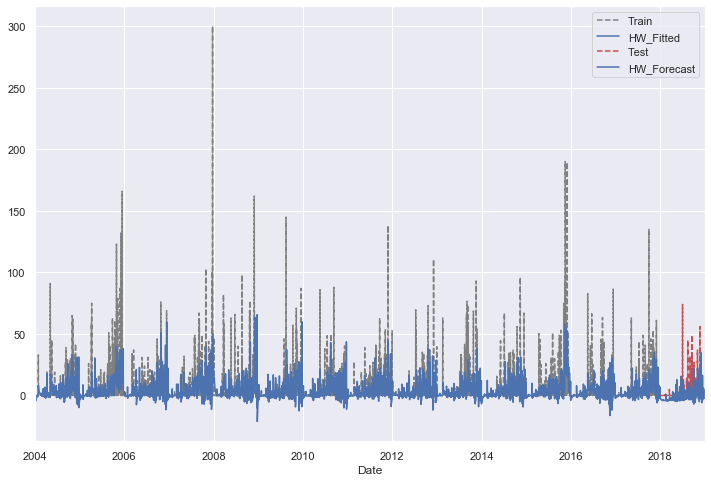

In [92]:
train["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted3.plot(color="b", legend=True, label="HW_Fitted")
predictions_rain["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")
predictions_rain["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

In [93]:
accuracy(predictions_rain['POONDI_rain'],predictions_rain["py_hw"] )

,%MAPE,RMSE
0,inf,8.6539


** Mean of the residuals:  -0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


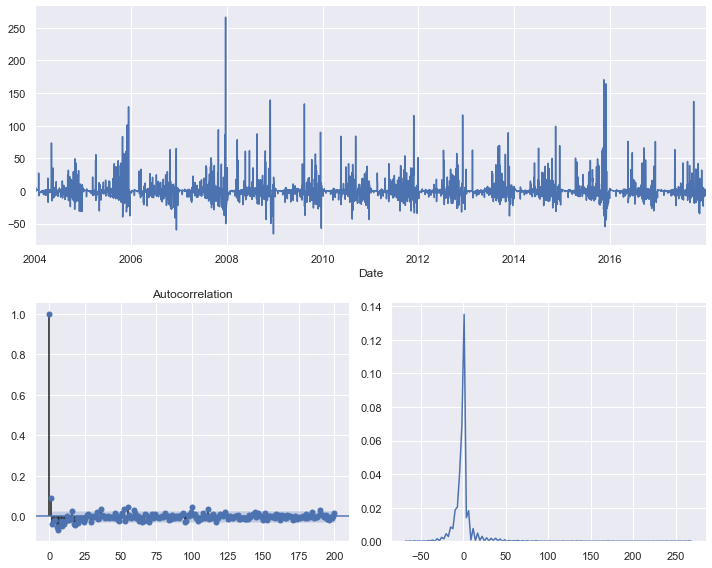

In [94]:
residcheck(hw_resid3.dropna(), lags = 200);

#### Holt's winter for POONDI rain with d=1

In [95]:
hw_model4 = ExponentialSmoothing(train_diff1["POONDI_rain"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=False)

hw_fitted4 = hw_model4.fittedvalues

hw_resid4 = hw_model4.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model4.forecast(len(test_diff1["POONDI_rain"])) + numpy.mean(hw_resid4)

predictions_rain_diff1["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model4.params_formatted

,name,param,optimized
smoothing_level,alpha,0.006020,True
smoothing_trend,beta,0.000120,True
smoothing_seasonal,gamma,0.145747,True
initial_level,l.0,4.566185,True
initial_trend,b.0,-0.000005,True
...,...,...,...
initial_seasons.360,s.360,-4.512131,True
initial_seasons.361,s.361,-4.520185,True
initial_seasons.362,s.362,-4.505851,True
initial_seasons.363,s.363,-4.526377,True


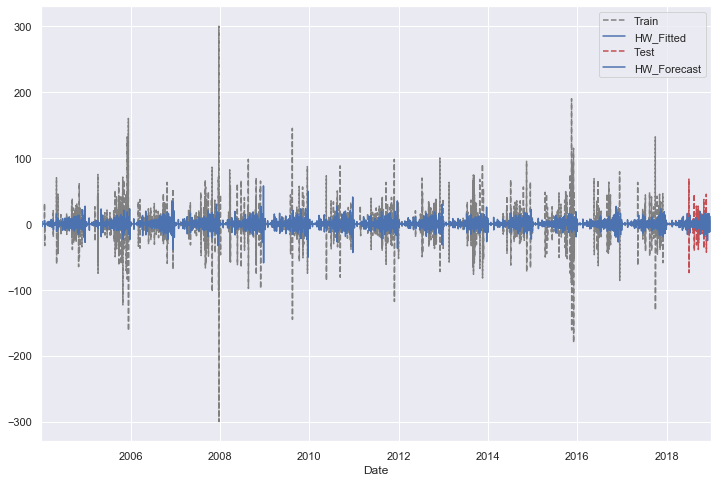

In [81]:
train_diff1["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted4.plot(color="b", legend=True, label="HW_Fitted")
predictions_rain_diff1["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")
predictions_rain_diff1["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

In [82]:
accuracy(predictions_rain_diff1['POONDI_rain'],predictions_rain_diff1["py_hw"] )

,%MAPE,RMSE
0,inf,10.209


** Mean of the residuals:  -0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


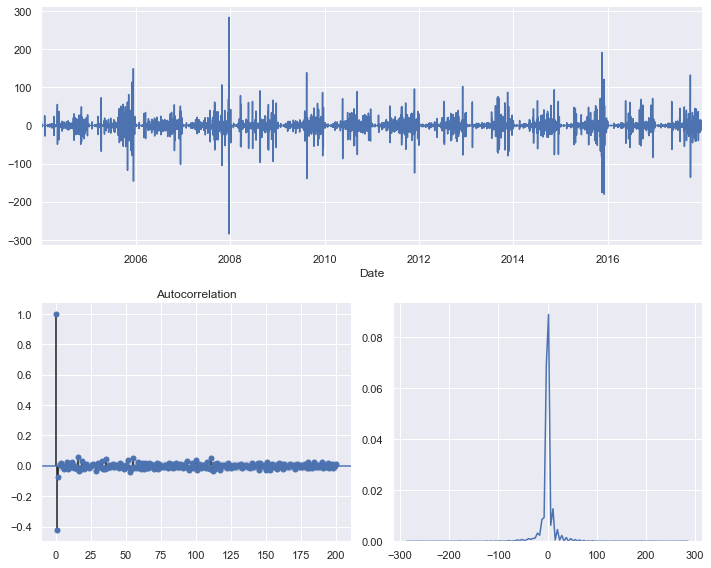

In [96]:
residcheck(hw_resid4.dropna(), lags = 200);

#### Note the optimized alpha, beta and gamma parameters.

    ** alpha: 0.79, i.e 79% weight was given to the last observation

    ** beta: learning parameter for trend. very small. Not much weight is given to the recent trend and trend is obatained from distant past

    ** gamma: seasonal factor is 0. gamma is usually very small (<0.2) and we want it to be small. If the gamma is high, it can lead to overfitting becuase it means the model is learning too much from recent the recenet data. 0 here indicates seasonality is learned from the earliest season.

#### Cross Validation Approach 
     When the time series is short, cross-validation should be used to make sure the model does not overfit the data.
     
>Expanding window cross-validation: We start with some initial training & test sets and with each iteration we add one observation to the training set. Forecast errors are calculated with each iteration and averaged to compare model performance. This simulates the performance of the model as we add more observations. For the final forecast we will using all the available history, so using expanding window gives us a good estimate of the forecast accuracy and uncertainty.

>Rolling Window cross-validation: Similar to Expanding but the training size remains same, instead it moves by one observation each time. Training and test lengths remain same.

In [49]:
## dataset was large, hence not doing this as it will take time to do this
# hw_cv(data["POONDI"], seasonal_periods=365, initial_train_window=3000, test_window=365)
# residcheck(hw_resid, lags = 100);


# ETS Model

    ETS standards for Error, Trend, Seasonality model (I have also seen some refer to it as ExponenTial Smoothing). It is similar to Holt-Winter's model above but with a State Space statistical framework. In HoltWinter's, the time series is decomposed into trend and seasonality and exponential weights are used to make the forecast. In a State Space approach, the underlying statistical process is identified and errors are factored in to make the forecast. Holt, Single Exponential Smoothing, Holt-Winter's, certain ARIMA models can all be categorised into ETS class models.

    ETS models follow a taxonomy of ETS(XYZ) where:

> X:Error (aka innovations). It can be Additive (A) or Multiplicative (M)

> Y:Trend. Trend component can be No trend (N), additive (A), Multiplicative (M) or damped (Ad)

> Z:Seasonality, Null (N), additive (A) or multiplicative (M)

    statsmodels() has a statespace implementation of exponential smoothing method in its tsa.statespace() class. It only has addditive error, additive & damped trend models for now (as of 4/20/2020). Recall that we can convert a multiplicative model into additive by power transform, so this is not a problem.

    Using statespace (ETS) can often work better than Holt Winter because of how the parameters are initialized and optimized. This can make a huge difference in the results as we will see. ETS framework also returns 95% predictive interval which HW does not.

In [ ]:
### since from the above as well as the plot it is evident that trend & seasonality is additive so not running the grid search
#here
#### got memory error because of high seasonality
# boxcox can also be used
# ets_t_T_d_F=sm.tsa.statespace.ExponentialSmoothing(train['POONDI'],
#                                            trend=True, 
#                                            initialization_method= 'heuristic', 
#                                            seasonal=365, 
#                                            damped_trend=False).fit()

# fc_LAdA = ets_t_T_d_F.forecast(365)

# predictions["ets_t_T_d_F"]=fc_LAdA

In [ ]:
# train["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
# ets_t_T_d_F.fittedvalues.plot(color="b", legend=True, label="t_T_d_F_Fitted")
# predictions["POONDI"].plot(style="--",color="r", legend=True, label="Test")
# predictions["ets_t_T_d_F"].plot(color="b", legend=True, label="t_T_d_F_Forecast");

In [ ]:
# accuracy(predictions["POONDI"],predictions["ets_t_T_d_F"])

In [97]:
# residcheck(ets_t_T_d_F.resid,lags = 100)

##### Notes
> The primary reason why ETS should perform better is the parameter initialization & optimization. Holt Winter's minimizes the residual error whereas ETS optimizes likelihood. ETS is more likely to obtain global minima faster & more accurately. This doesnt mean ETS will always be better, but in general it should perform better.
    

# SARIMA  Or Auto Arima Model



In [ ]:
plot_acf(train['POONDI_rain'])
plot_pacf(train['POONDI_rain'])

In [ ]:
### Pre-Processing
def lagged_feature(ts, n=3):
    s = ts.copy()
    for i in range(n):
        s_new = ts.shift(i+1)
        s_new.name = ts.name+'_lag_'+str((i+1))
        s = pandas.concat([s, s_new], axis=1)
    s = s.fillna(method='bfill')
    return s

In [291]:
y, reservoir_exog = FourierFeaturizer(m=365, k=2).fit_transform(train['POONDI'])
all_exog_train = pandas.concat([reservoir_exog.set_index(train['POONDI_rain'].index), lagged_feature(train['POONDI_rain'],n=15)], axis=1)
# all_exog_train = reservoir_exog

In [311]:
# TODO: add fourier term to reservoir, see for m=12 (very slow), better forecast of rain, train without rain variable

model_Poondi_d1 = pm.auto_arima(train['POONDI'], exogenous = all_exog_train,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=1, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
print(model_Poondi_d1.summary())
model_fit_d1 = pandas.Series(index=train['POONDI'].index, data=model_Poondi_d1.predict_in_sample(exogenous=all_exog_train))
model_resid_d1 = pandas.Series(index=train['POONDI'].index, data=model_Poondi_d1.resid())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=59133.341, BIC=59290.290, Time=8.001 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=59928.798, BIC=60072.668, Time=1.047 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=59175.640, BIC=59326.049, Time=6.740 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=59167.455, BIC=59317.864, Time=12.409 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=59926.825, BIC=60064.155, Time=13.704 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=59128.570, BIC=59292.059, Time=16.838 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=59126.577, BIC=59283.526, Time=10.199 seconds
Fit ARIMA: (3, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=59128.561, BIC=59292.050, Time=13.732 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=59050.420, BIC=59220.448, Time=30.074 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True);

In [312]:
model_Poondi_d0 = pm.auto_arima(train['POONDI'], exogenous = all_exog_train,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=0, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
print(model_Poondi_d0.summary())
model_fit_d0 = pandas.Series(index=train['POONDI'].index, data=model_Poondi_d0.predict_in_sample(exogenous=all_exog_train))
model_resid_d0 = pandas.Series(index=train['POONDI'].index, data=model_Poondi_d0.resid())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=59322.096, BIC=59479.049, Time=27.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=84199.111, BIC=84342.986, Time=10.468 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=59980.505, BIC=60130.919, Time=18.119 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=78668.835, BIC=78819.248, Time=23.010 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=87387.110, BIC=87524.444, Time=5.633 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=59296.315, BIC=59459.809, Time=28.633 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=59287.248, BIC=59444.202, Time=25.642 seconds
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to inf (at least on

#### Without fourier exog variable for reservoir performance is very bad

In [313]:
y, reservoir_exog = FourierFeaturizer(m=365, k=2).fit_transform(train['POONDI'], n_periods=365)
all_exog_test_naive = pandas.concat([reservoir_exog.set_index(test['POONDI_rain'].index), lagged_feature(predictions_rain['py_snaive'],n=15)], axis=1)
all_exog_test_hw = pandas.concat([reservoir_exog.set_index(test['POONDI_rain'].index), lagged_feature(predictions_rain['py_hw'],n=15)], axis=1)
all_exog_test_AR = pandas.concat([reservoir_exog.set_index(test['POONDI_rain'].index), lagged_feature(predictions_rain['auto_arima'],n=15)], axis=1)

In [314]:
predictions['auto_arima_snaive_d1'] = model_Poondi_d1.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_naive)
predictions['auto_arima_hw_d1'] = model_Poondi_d1.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_hw)
predictions['auto_arima_AR_d1'] = model_Poondi_d1.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_AR)

predictions['auto_arima_snaive_d0'] = model_Poondi_d0.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_naive)
predictions['auto_arima_hw_d0'] = model_Poondi_d0.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_hw)
predictions['auto_arima_AR_d0'] = model_Poondi_d0.predict(n_periods=365, return_conf_int=False, exogenous=all_exog_test_AR)
# predictions['auto_arima_fourier'] = model_Poondi.predict(n_periods=365, return_conf_int=False, exogenous=reservoir_exog)

In [210]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer, LogEndogTransformer, FourierFeaturizer

# pipe = Pipeline([
#     ("fourier", FourierFeaturizer(m=365, k=2)),
#     ("arima", pm.AutoARIMA(stepwise=True, trace=1, error_action="ignore", d=1,
#                               seasonal=False,  # because we use Fourier
#                               suppress_warnings=True))
# ])

# pipe.fit(train['POONDI'])
# print(pipe.summary())
# model_fit = pandas.Series(index=train['POONDI'].index, data=pipe.predict_in_sample(exogenous=None, return_conf_int=False).values)
# predictions_rain['auto_arima'] = pipe.predict(n_periods=365, return_conf_int=False, exogenous=None)
# model_resid = pandas.Series(index=train['POONDI'].index, data=train['POONDI'] - model_fit)

In [319]:
predictions['auto_arima_snaive_d1'] = numpy.where(predictions['auto_arima_snaive_d1']<0, 0.0, predictions['auto_arima_snaive_d1'])
predictions['auto_arima_hw_d1'] = numpy.where(predictions['auto_arima_hw_d1']<0, 0.0, predictions['auto_arima_hw_d1'])
predictions['auto_arima_AR_d1'] = numpy.where(predictions['auto_arima_AR_d1']<0, 0.0, predictions['auto_arima_AR_d1'])

predictions['auto_arima_snaive_d0'] = numpy.where(predictions['auto_arima_snaive_d0']<0, 0.0, predictions['auto_arima_snaive_d0'])
predictions['auto_arima_hw_d0'] = numpy.where(predictions['auto_arima_hw_d0']<0, 0.0, predictions['auto_arima_hw_d0'])
predictions['auto_arima_AR_d0'] = numpy.where(predictions['auto_arima_AR_d0']<0, 0.0, predictions['auto_arima_AR_d0'])
# predictions['auto_arima_fourier'] = numpy.where(predictions['auto_arima_fourier']<0, 0.0, predictions['auto_arima_fourier'])




In [332]:
predictions['ensemble1'] = predictions[['py_snaive', 'py_hw', 'auto_arima_fourier','auto_arima_snaive_d1', 
                                      'auto_arima_hw_d1', 'auto_arima_AR_d1','auto_arima_snaive_d0', 'auto_arima_hw_d0', 
                                      'auto_arima_AR_d0']].mean(axis=1)
predictions['ensemble2'] = predictions[['auto_arima_snaive_d1', 
                                      'auto_arima_hw_d1', 'auto_arima_AR_d1','auto_arima_snaive_d0', 'auto_arima_hw_d0', 
                                      'auto_arima_AR_d0']].mean(axis=1)

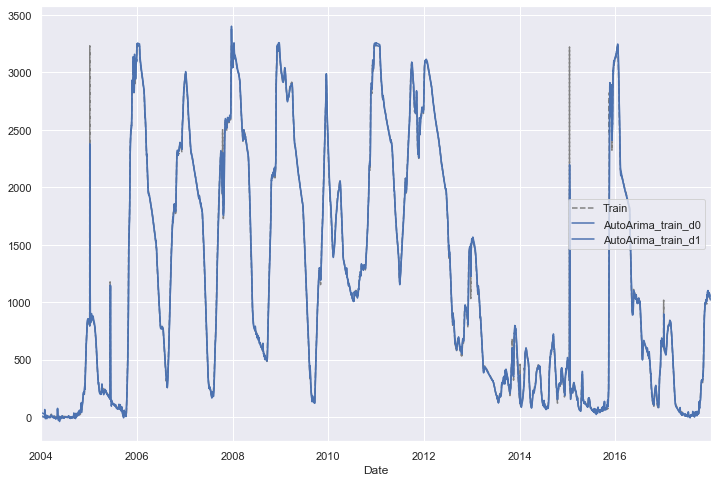

In [316]:
train["POONDI"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
model_fit_d0.plot(color="b", legend=True, label="AutoArima_train_d0")
model_fit_d1.plot(color="b", legend=True, label="AutoArima_train_d1")

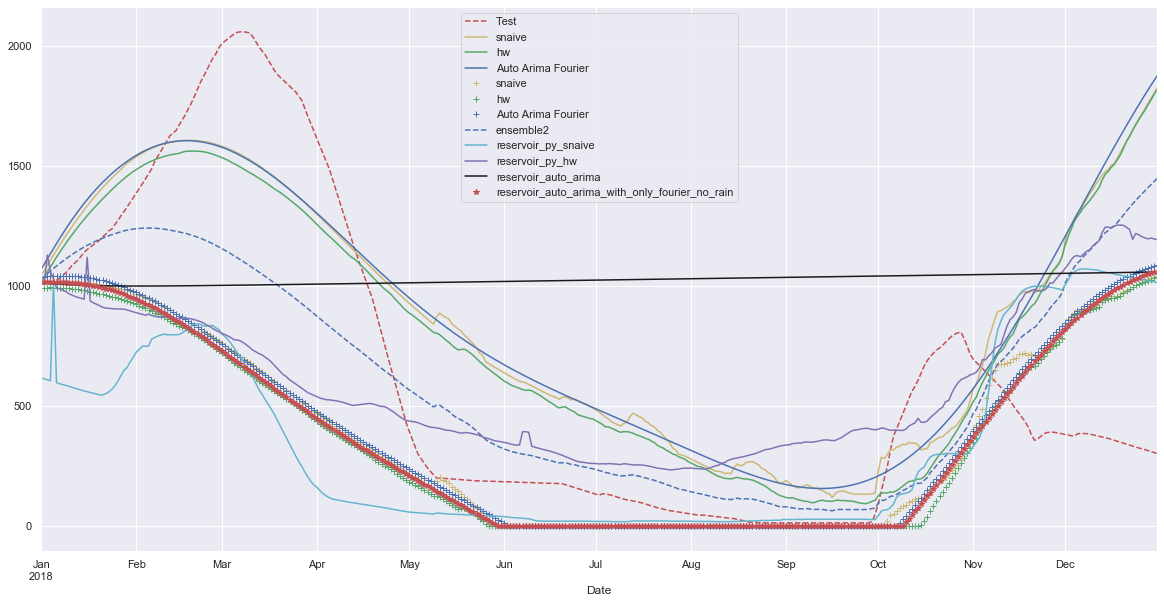

In [336]:
predictions["POONDI"].plot(style="--",color="r", legend=True, label="Test")
predictions["auto_arima_snaive_d0"].plot(color="y", legend=True, label="snaive");
predictions["auto_arima_hw_d0"].plot(color="g", legend=True, label="hw");
predictions["auto_arima_AR_d0"].plot(color="b", legend=True, label="Auto Arima Fourier");

predictions["auto_arima_snaive_d1"].plot(style="+",color="y", legend=True, label="snaive");
predictions["auto_arima_hw_d1"].plot(style="+",color="g", legend=True, label="hw");
predictions["auto_arima_AR_d1"].plot(style="+",color="b", legend=True, label="Auto Arima Fourier");

predictions["ensemble2"].plot(style="--",color="b", legend=True, label="ensemble2");

predictions["py_snaive"].plot(color="c", legend=True, label="reservoir_py_snaive");
predictions["py_hw"].plot(color="m", legend=True, label="reservoir_py_hw");
predictions["auto_arima"].plot(color="k", legend=True, label="reservoir_auto_arima");
predictions["auto_arima_fourier"].plot(style="*",color="r", legend=True, label="reservoir_auto_arima_with_only_fourier_no_rain");

In [333]:
print(accuracy(predictions['POONDI'],predictions["auto_arima"] ))  #normal auto arima with no fourier and all
print(accuracy(predictions['POONDI'],predictions["py_hw"] ))   #holt winter on reservoir
print(accuracy(predictions['POONDI'],predictions["py_snaive"] ))   #naive on reservoir

print('with d0')
print(accuracy(predictions['POONDI'],predictions["auto_arima_snaive_d0"] ))  #fourier + lagged rain with snaive
print(accuracy(predictions['POONDI'],predictions["auto_arima_hw_d0"] ))    #fourier + lagged rain with hw
print(accuracy(predictions['POONDI'],predictions["auto_arima_AR_d0"] ))    #fourier + lagged rain with AR

print('with d1')
print(accuracy(predictions['POONDI'],predictions["auto_arima_snaive_d1"] ))  #fourier + lagged rain with snaive
print(accuracy(predictions['POONDI'],predictions["auto_arima_hw_d1"] ))    #fourier + lagged rain with hw
print(accuracy(predictions['POONDI'],predictions["auto_arima_AR_d1"] ))    #fourier + lagged rain with AR

print(accuracy(predictions['POONDI'],predictions["auto_arima_fourier"] ))    #fourier


print(accuracy(predictions['POONDI'],predictions["ensemble1"] ))    #fourier

print(accuracy(predictions['POONDI'],predictions["ensemble2"] ))    #fourier

       %MAPE      RMSE
0  1239.3687  756.6879
      %MAPE     RMSE
0  399.9571  570.936
    %MAPE      RMSE
0  85.855  649.3457
with d0
      %MAPE      RMSE
0  283.6443  476.5425
      %MAPE      RMSE
0  227.3354  466.1884
      %MAPE      RMSE
0  291.0202  486.5112
with d1
     %MAPE      RMSE
0  78.7455  554.2091
     %MAPE      RMSE
0  81.5538  574.7516
    %MAPE    RMSE
0  79.412  556.27
     %MAPE      RMSE
0  80.6379  567.8867
      %MAPE     RMSE
0  137.2096  482.259
      %MAPE      RMSE
0  132.9855  448.6794


In [ ]:
residcheck(model_resid.dropna(), lags = 200);

### First we need to forecast Rainfall

In [206]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer, LogEndogTransformer, FourierFeaturizer

pipe = Pipeline([
    ("fourier", FourierFeaturizer(m=365, k=2)),
    ("arima", pm.AutoARIMA(stepwise=True, trace=1, error_action="ignore", d=0,
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(train['POONDI_rain'])
print(pipe.summary())
model_fit = pandas.Series(index=train['POONDI_rain'].index, data=pipe.predict_in_sample(exogenous=None, return_conf_int=False).values)
predictions_rain['auto_arima'] = pipe.predict(n_periods=365, return_conf_int=False, exogenous=None)
model_resid = pandas.Series(index=train['POONDI_rain'].index, data=train['POONDI_rain'] - model_fit)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=40499.826, BIC=40565.223, Time=13.417 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=40721.976, BIC=40761.215, Time=0.691 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=40521.251, BIC=40567.029, Time=0.799 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=40538.314, BIC=40584.092, Time=3.745 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=41094.393, BIC=41127.092, Time=2.784 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=40498.608, BIC=40557.465, Time=8.935 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=40526.381, BIC=40578.699, Time=6.004 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=40507.763, BIC=40560.081, Time=5.524 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=40499.529, BIC=40564.926, Time=10.021 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC

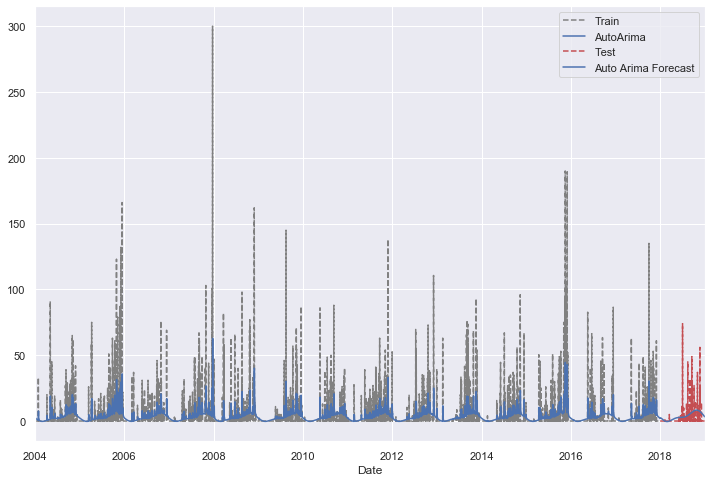

In [207]:
train["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
model_fit.plot(color="b", legend=True, label="AutoArima")
predictions_rain["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")
predictions_rain["auto_arima"].plot(color="b", legend=True, label="Auto Arima Forecast");

In [211]:
print(accuracy(predictions_rain['POONDI_rain'],predictions_rain["auto_arima"] ))
print(accuracy(predictions_rain['POONDI_rain'],predictions_rain["py_hw"] ))
print(accuracy(predictions_rain['POONDI_rain'],predictions_rain["py_snaive"] ))

   %MAPE    RMSE
0    inf  7.5318
   %MAPE    RMSE
0    inf  8.6539
   %MAPE     RMSE
0    NaN  12.6088


** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.203 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


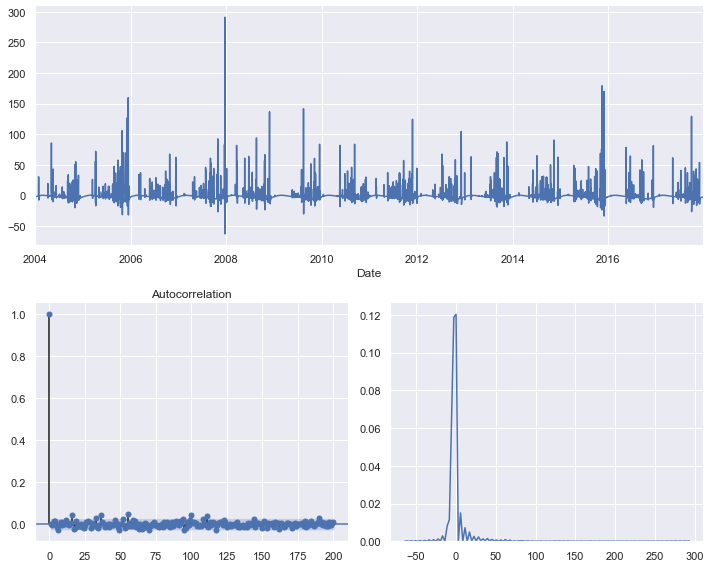

In [169]:
residcheck(model_resid.dropna(), lags = 200);

In [ ]:
# use boxcox transform pipeline
# use fourrier seasonality as exogenous variable for auto arima for rain
# use lag of rain to predict reservoir as exogenous variable with seasonality false & true

# use fbprohet to predict rain and then auto arima

# compare all & ensemble

#### ETS/HW & SARIMA cannot work with multiple seasonalities & high frequency data. Prophet was built for high frequency data like daily, hourly, minute etc.. It may not work very well on monthly, quarterly data. Prophet can also include effect of holidays.

> Prophet requires the data to be in specific format. Dataframe must have time column ds and time series observations in column y

# Prophet

In [378]:
from fbprophet import Prophet

prophet_train = train[['POONDI_rain']].reset_index()
prophet_train.columns = ['ds', 'y']
prophet_test = test[['POONDI_rain']].reset_index()
prophet_test.columns = ['ds', 'y']

In [339]:
?Prophet

In [380]:
#Fit the model to train
n_changepoints_list = [2,5,10,15,25]
seasonality_prior_scale_list = [0.1, 1,5,10]
changepoint_prior_scale_list = [0.05, 0.1, 0.5, 1]
count_=1
output_rain = pandas.DataFrame(columns=['iter', 'train_mape','train_rmse', 'test_mape','test_rmse'])
for n1 in n_changepoints_list:
    for s1 in seasonality_prior_scale_list:
        for c1 in changepoint_prior_scale_list:
            fb1_model=Prophet(weekly_seasonality=True,
                       daily_seasonality=False, n_changepoints=n1, seasonality_prior_scale=s1, changepoint_prior_scale=c1,
                       seasonality_mode="additive").fit(prophet_train)

            #Prophet results are saved to a dataframe using make_future_dataframe()
            fb1_df=fb1_model.make_future_dataframe(365, freq='D') #set the freq argument to 'Q' for quarterly data
            fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]
            #Residuals
            print('iter------', count_)
            print('accuracy training set')
            fitted_val = fb1_fc_df.set_index('ds')["yhat"].iloc[:-len(test)]
            x = accuracy(prophet_train['y'].values,fitted_val.values)
            fb1_resid = prophet_train['y'].values - fb1_fc_df['yhat'].iloc[:-len(test)]
            forecast = fb1_fc_df.iloc[-len(test):]
            print('accuracy test set')
            y = accuracy(predictions["POONDI"],forecast["yhat"].values)
            
            output_rain = output_rain.append(pandas.DataFrame(columns=['iter', 'train_mape','train_rmse', 'test_mape','test_rmse'],
                                          data=[[count_, x.iloc[0,0],x.iloc[0,1],y.iloc[0,0],y.iloc[0,1]]]))
            count_ += 1

iter------ 1
accuracy training set
accuracy test set
iter------ 2
accuracy training set
accuracy test set
iter------ 3
accuracy training set
accuracy test set
iter------ 4
accuracy training set
accuracy test set
iter------ 5
accuracy training set
accuracy test set
iter------ 6
accuracy training set
accuracy test set
iter------ 7
accuracy training set
accuracy test set
iter------ 8
accuracy training set
accuracy test set
iter------ 9
accuracy training set
accuracy test set
iter------ 10
accuracy training set
accuracy test set
iter------ 11
accuracy training set
accuracy test set
iter------ 12
accuracy training set
accuracy test set
iter------ 13
accuracy training set
accuracy test set
iter------ 14
accuracy training set
accuracy test set
iter------ 15
accuracy training set
accuracy test set
iter------ 16
accuracy training set
accuracy test set


iter------ 17
accuracy training set
accuracy test set
iter------ 18
accuracy training set
accuracy test set
iter------ 19
accuracy training set
accuracy test set
iter------ 20
accuracy training set
accuracy test set
iter------ 21
accuracy training set
accuracy test set
iter------ 22
accuracy training set
accuracy test set
iter------ 23
accuracy training set
accuracy test set
iter------ 24
accuracy training set
accuracy test set
iter------ 25
accuracy training set
accuracy test set
iter------ 26
accuracy training set
accuracy test set
iter------ 27
accuracy training set
accuracy test set
iter------ 28
accuracy training set
accuracy test set
iter------ 29
accuracy training set
accuracy test set
iter------ 30
accuracy training set
accuracy test set
iter------ 31
accuracy training set
accuracy test set
iter------ 32
accuracy training set
accuracy test set
iter------ 33
accuracy training set
accuracy test set
iter------ 34
accuracy training set
accuracy test set
iter------ 35
accuracy train

In [381]:
print(output_rain.to_string())

  iter  train_mape  train_rmse  test_mape  test_rmse
0    1         inf     12.8908    94.1540   904.8502
0    2         inf     12.8905    94.3903   904.9646
0    3         inf     12.8904    94.5811   905.0562
0    4         inf     12.8904    94.6079   905.0699
0    5         inf     12.8908    94.1475   904.8472
0    6         inf     12.8905    94.4022   904.9709
0    7         inf     12.8904    94.5888   905.0610
0    8         inf     12.8904    94.6112   905.0717
0    9         inf     12.8908    94.1473   904.8471
0   10         inf     12.8905    94.3926   904.9660
0   11         inf     12.8904    94.6123   905.0724
0   12         inf     12.8904    94.6113   905.0716
0   13         inf     12.8908    94.1473   904.8471
0   14         inf     12.8905    94.3824   904.9607
0   15         inf     12.8904    94.5801   905.0563
0   16         inf     12.8904    94.6113   905.0716
0   17         inf     12.8877    94.3605   904.9362
0   18         inf     12.8863    94.7432   90

In [370]:
prophet_train = train[['POONDI']].reset_index()
prophet_train.columns = ['ds', 'y']
prophet_test = test[['POONDI']].reset_index()
prophet_test.columns = ['ds', 'y']

In [383]:
fb1_model=Prophet(weekly_seasonality=True,
                       daily_seasonality=False, n_changepoints=10, seasonality_prior_scale=1, changepoint_prior_scale=0.5,
                       seasonality_mode="additive").fit(prophet_train)

#Prophet results are saved to a dataframe using make_future_dataframe()
fb1_df=fb1_model.make_future_dataframe(365, freq='D') #set the freq argument to 'Q' for quarterly data
fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]
#Residuals
print('iter------', count_)
print('accuracy training set')
fitted_val = fb1_fc_df.set_index('ds')["yhat"].iloc[:-len(test)]
x = accuracy(prophet_train['y'].values,fitted_val.values)
fb1_resid = prophet_train['y'].values - fb1_fc_df['yhat'].iloc[:-len(test)]
forecast = fb1_fc_df.iloc[-len(test):]
print('accuracy test set')
y = accuracy(predictions_rain["POONDI_rain"],forecast["yhat"].values)

output = output.append(pandas.DataFrame(columns=['iter', 'train_mape','train_rmse', 'test_mape','test_rmse'],
                              data=[[count_, x.iloc[0,0],x.iloc[0,1],y.iloc[0,0],y.iloc[0,1]]]))
count_ += 1
fb1_fc__=fb1_model.predict(fb1_df)

iter------ 81
accuracy training set
accuracy test set


In [372]:
forecast.set_index(['ds'])['yhat']

ds
2018-01-01    1378.611357
2018-01-02    1380.377747
2018-01-03    1379.136706
2018-01-04    1381.628393
2018-01-05    1378.914641
                 ...     
2018-12-27    1314.219964
2018-12-28    1314.835945
2018-12-29    1320.266142
2018-12-30    1317.191221
2018-12-31    1315.063105
Name: yhat, Length: 365, dtype: float64

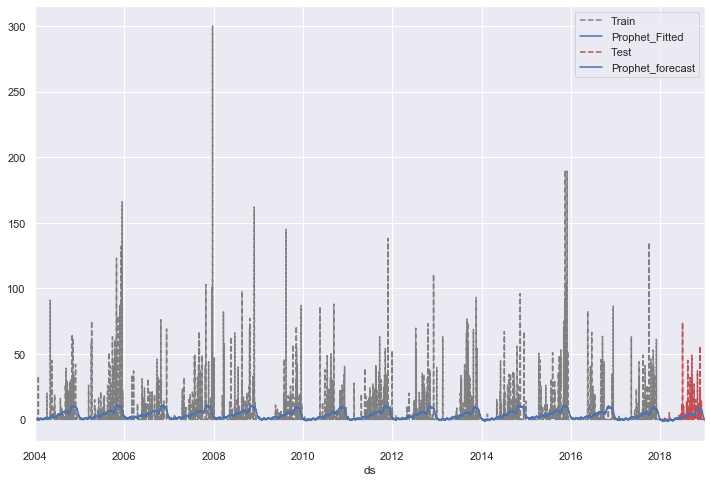

In [384]:
train["POONDI_rain"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fitted_val.plot(color="b", legend=True, label="Prophet_Fitted")

predictions_rain["POONDI_rain"].plot(style="--",color="r", legend=True, label="Test")

forecast.set_index(['ds'])['yhat'].plot(color="b", legend=True, label="Prophet_forecast");

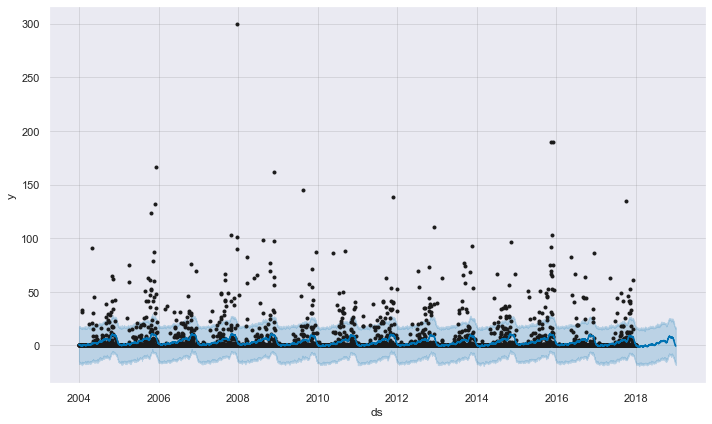

In [385]:
fb1_model.plot(fb1_fc__);

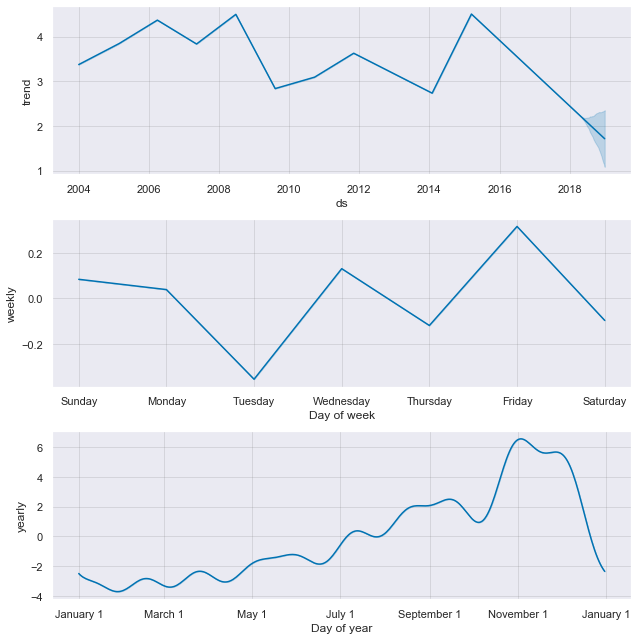

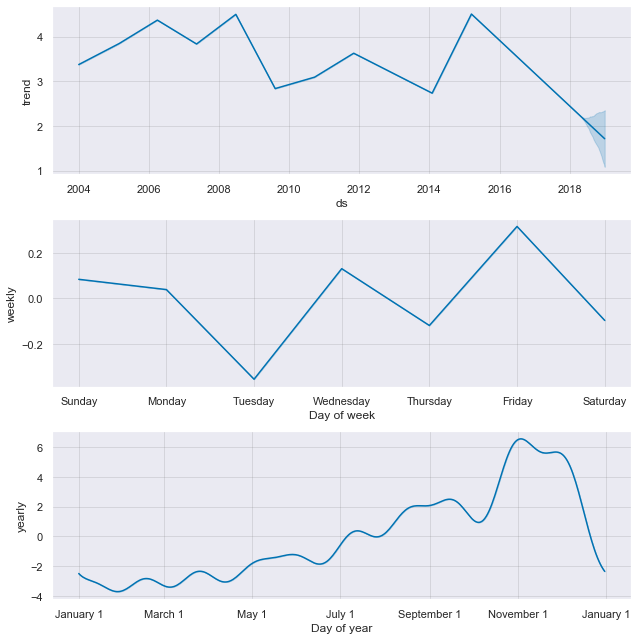

In [386]:
fb1_model.plot_components(fb1_fc__)


** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


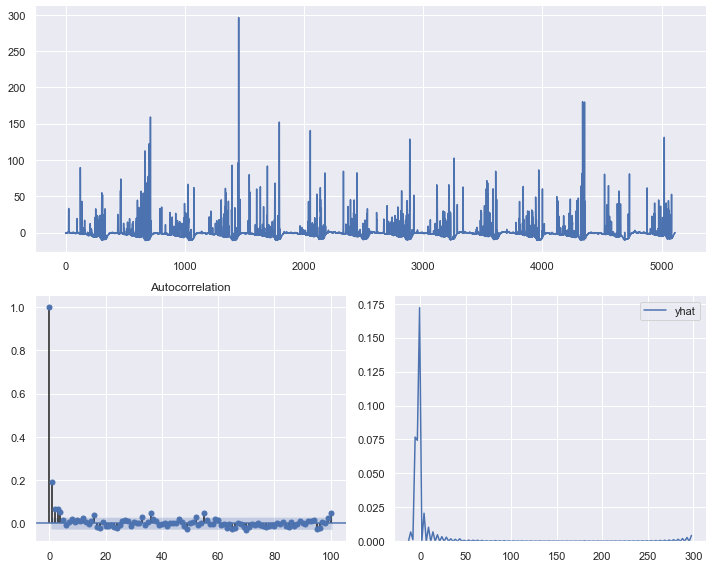

In [387]:
residcheck(fb1_resid,100);

In [ ]:
print(accuracy(predictions['POONDI_rain'],predictions_rain["auto_arima"] ))

# Ensemble

In [ ]:
# try multiple combination of them

# Notes
https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html

#### Forecast Uncertainty
    Forecasts have four sources of uncertainties:

    1.) Random error
    2.) Parameters used in the model
    3.) Model choice
    4.) Data uncertainty
    

#### Simulations
    Since here we are interested in the total reservoir capacity and not for particular reservoir. The obvious way is to calculate forecasts for each reservoir, like we did, and then summing them up to get total capacity. While this may provide a good estimate, it will not be correct. Since the forecasts are distributions, we need to account for the variance in those distributions when calculating the aggregates. If the forecasts were based on median or percentile, we cannot simply add them up. Also, it's possible that not all forecasts are from normal distributions and thus cannot be added.
    
    Monte Carlo simulation can be used to overcome these challenges. Below we will generate 5000 future forecasts based on the ETS model we have and then calculate the aggregates, prediction intervals and cumulative distribution function for it.
    eg: 
<code>
sim_frame=ets_model.simulate(4,  anchor='2018-03-31',repetitions=5000).T.reset_index().iloc[:,2:].apply(np.exp).round(1) 
sim_frame["aggregate"] = sim_frame.sum(axis=1)
sim_frame.tail()
num_bins = 100
counts, bin_edges = np.histogram (sim_frame["aggregate"], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
cdf_x = bin_edges[1:]
cdf_y = cdf/cdf[-1]
cdf_df = pd.DataFrame({'Sales':cdf_x, 'Percentile':cdf_y})
cdf_df.head()
</code>
    
#### Confidence Interval vs. Prediction Interval

    It's common to calculate and show 95% confidence around the mean forecast. 95% is a conventional measure and doesn't have any particular significance. Confidence interval (CI)is not the same as prediction interval (PI). CI is often confused as a measure of uncertainty and is used to show the upper and lower bound for the estimate - it's not!
    
    Confidence interval is around the population point estimate. e.g. if we calculate the mean, to convey the error in calculating it we compute the CI. In our case the mean for Q1 is 692.5 and lower and upper CI bound are [599.8,799.5]. We are 95% confident that the mean will be within this bound. This doesn't say the forecast will be between these bounds with 95% confidence. Think of CI as error around the population point estimate because of limited sample size. CI will be lower if increase the sample size or lower the alpha. Point estimate means calculating a single number e.g. mean, median, percentile etc. about the population/sample. Also make a note if the CI is calculated using parameters of the models (residuals).

In [ ]:
# myaproach:
#Case1:
    # step1: predict rainfall using HMM or FBPROPHET or the same analysis for all come up with the best rainfall prediction
    # step2: use AutoArima model to predict reservoir using rainfall but here we have to use different lag of rainfall as 
    #         exogenous variable

#Case2:
    # use regression model to find beta, make the reservoir series stationary somehow by subtracting rainfall data & predict that
    # series and then add prediction of rainfall to it.
    
#need to work upon 
   # best rainfall prediction model

